**Data Mining Project, midterm 2021/2022**




**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 1.1 Data Understanding**

##**Importing libraries and extracting datasets**

First we have to import the necessary libraries to work within our project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import scipy
import seaborn as sn
import requests
import zipfile

The dataset is inside a zip file, so we need to extract it.

In [2]:
dataset_link = 'http://didawiki.cli.di.unipi.it/lib/exe/fetch.php/magistraleinformatica/dmi/prj_data.zip'
r = requests.get(dataset_link, allow_redirects=True)
open('prj_data.zip', 'wb').write(r.content)
with zipfile.ZipFile("prj_data.zip", 'r') as zip_ref:
     zip_ref.extractall()

**Load the datasets**

Read the data from the three csv files, each one is assigned to a different dataframe for now.

In [3]:
df_male = pd.read_csv("male_players.csv", sep=",")  # dataframe of male players
df_female = pd.read_csv("female_players.csv", sep=",")  # dataframe of female players
df_matches = pd.read_csv("tennis_matches.csv", sep=",", index_col=0)  # matches dataframe

##**Data semantics**

Before we deal with the main task (missing values and outliers detection) we need to show some informations about the project datasets and solve some first issues.

###**Some informations about the dataset**

The players' dataframes, men and women, contain only the name and surname of the players (most of them are retired from the competitions and can't be found in any match record). That's why we decided to focus our work only on the matches dataframe.

In [4]:
df_matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,R,178.0,JPN,95.000000,106421.0,NaN,Daniil Medvedev,R,198.0,RUS,22.885695,6-4 3-6 6-2,3.0,F,124.0,3.0,3.0,77.0,44.0,31.0,17.0,13.0,3.0,6.0,8.0,6.0,100.0,54.0,34.0,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,R,198.0,RUS,22.885695,104542.0,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.705681,7-6(6) 6-2,3.0,SF,82.0,10.0,1.0,52.0,33.0,28.0,14.0,10.0,0.0,1.0,17.0,2.0,77.0,52.0,36.0,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,R,178.0,JPN,29.004791,104871.0,NaN,Jeremy Chardy,R,188.0,FRA,31.882272,6-2 6-2,3.0,SF,66.0,2.0,2.0,47.0,33.0,26.0,9.0,8.0,2.0,2.0,10.0,3.0,46.0,27.0,15.0,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.705681,200282.0,NaN,Alex De Minaur,R,183.0,AUS,19.868583,6-4 7-6(2),3.0,QF,106.0,12.0,2.0,68.0,43.0,34.0,15.0,11.0,4.0,5.0,1.0,2.0,81.0,60.0,38.0,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,R,198.0,RUS,22.885695,105683.0,NaN,Milos Raonic,R,196.0,CAN,28.010951,6-7(2) 6-3 6-4,3.0,QF,129.0,12.0,3.0,105.0,68.0,48.0,25.0,16.0,8.0,8.0,29.0,5.0,94.0,56.0,46.0,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,NaN,NaN,Hard,32.0,NaN,20171113.0,250.0,NaN,NaN,NaN,NaN,NaN,NaN,26.206708,206075.0,NaN,NaN,NaN,NaN,NaN,26.904860,3-6 6-2 6-3,NaN,NaN,NaN,NaN,1.0,NaN,49.0,38.0,16.0,NaN,7.0,NaN,1.0,3.0,93.0,NaN,NaN,NaN,NaN,7.0,11.0,NaN,322.0,280.0,183.0,NaN,NaN
186124,NaN,Taipei,NaN,32.0,C,20171113.0,NaN,NaN,NaN,Veronika Kudermetova,NaN,175.0,NaN,NaN,214562.0,WC,Ingrid Neel,NaN,NaN,USA,NaN,7-6(3) 6-2,NaN,NaN,71.0,10.0,8.0,63.0,NaN,32.0,NaN,10.0,2.0,5.0,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,255.0,217.0,704.0,NaN,NaN,NaN
186125,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,Dalila Jakupovic,NaN,NaN,NaN,26.642026,201674.0,NaN,NaN,R,NaN,UZB,NaN,NaN,3.0,NaN,70.0,NaN,2.0,55.0,NaN,NaN,NaN,NaN,6.0,8.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
186126,NaN,NaN,NaN,32.0,C,20171113.0,NaN,NaN,NaN,Vitalia Diatchenko,NaN,170.0,RUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-6 6-2 6-4,3.0,NaN,115.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.0,75.0,NaN,NaN,13.0,NaN,3.0,NaN,176.0,NaN,NaN,NaN,3535.0,NaN


We found that the last records of the matches dataset (the Taipei tournament) are missing a lot of values, but, for now, let's take a look at the dataset info and plot its heatmap, so we can take a wider look at the missing values.

In [5]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186128 entries, 0 to 186127
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          186073 non-null  object 
 1   tourney_name        186103 non-null  object 
 2   surface             185940 non-null  object 
 3   draw_size           186099 non-null  float64
 4   tourney_level       186099 non-null  object 
 5   tourney_date        186100 non-null  float64
 6   match_num           186101 non-null  float64
 7   winner_id           186073 non-null  float64
 8   winner_entry        25827 non-null   object 
 9   winner_name         186101 non-null  object 
 10  winner_hand         186082 non-null  object 
 11  winner_ht           49341 non-null   float64
 12  winner_ioc          186099 non-null  object 
 13  winner_age          183275 non-null  float64
 14  loser_id            186100 non-null  float64
 15  loser_entry         44154 non-null

In [6]:
df_matches.dropna(subset=['tourney_id']).isna().any()

tourney_id            False
tourney_name          False
surface                True
draw_size             False
tourney_level         False
tourney_date          False
match_num             False
winner_id             False
winner_entry           True
winner_name           False
winner_hand            True
winner_ht              True
winner_ioc            False
winner_age             True
loser_id              False
loser_entry            True
loser_name            False
loser_hand             True
loser_ht               True
loser_ioc             False
loser_age              True
score                  True
best_of               False
round                 False
minutes                True
w_ace                  True
w_df                   True
w_svpt                 True
w_1stIn                True
w_1stWon               True
w_2ndWon               True
w_SvGms                True
w_bpSaved              True
w_bpFaced              True
l_ace                  True
l_df                

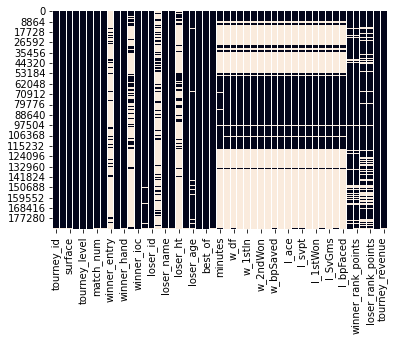

In [7]:
sn.heatmap(df_matches.isnull(), cbar=False)

###**Informations about the features**

We briefly list the features and what they are before starting our work of data integration.

####**Categorical attributes:**

* **tourney_id**
  * type: **String**.
  * it's composed by the year and a serial code unique for each tournament.
* **tourney_name**
  * type: **String**.
  * name of the tournament (actually the city where it was played).
* **surface**
  * type: **String**.
  * surface of the tournament (hard, clay, grass, carpet).
* **tourney_level**
  * type: **String**.
  * the type of tournament for men and women, the latter share some tournaments with the former.
* **winner_id and loser_id**
  * type: **String**.
  * ids of the players.
* **winner_entry and loser_entry**
  * type: **String**.
  * tells how the player qualified to the tournament.
* **winner_name and loser_name**
  * type: **String**.
  * name of players.
* **winner_hand and loser_hand**
  * type: **String**.
  * preferred hand of the players (R, L, U).
* **winner_ioc and loser_ioc**
  * type: **String**.
  * nationality of the players.
* **score**
  * type: **String**.
  * score of the match.
* **round**
  * type: **String**.
  * round of the match (e.g. F stands for final and SF for semifinal).



####**Numerical features**

* **draw_size**
  * type: **Float then Int**.
  * the rounds of the tournament (as an example 32 means that the starting brackt is composed by 32 matches).
* **tourney_date**
  * type: **Float then Datetime**.
  * the date of the first match of the tournament.
* **match_num**
  * type: **Float then Int**.
  * the match progressive number inside the tournament, sometimes is completely arbitrary.
* **winner_ht and loser_ht**
  * type: **Float then Int**.
  * height fo the players.
* **winner_age and loser_age**
  * type: **Float then Int**.
  * age of the players at the match date.
* **best_of**
  * type: **Float then Int**.
  * number of sets needed to win the match (3 or 5).
* **minutes**
  * type: **Float then Int**.
  * how long the match lasted.
* **w_ace and l_ace**
  * type: **Float then Int**.
  * number aces (valid serve won, first or second, not touched by the opposing player).
* **w_df and l_df**
  * type: **Float then Int**.
  * number of double faults committed by the players (more specifically the number of invalid second serves).
* **w_svpt and l_svpt**
  * type: **Float then Int**.
  * this may be confusing, it isn't the number of points obtained during the player's serves but the number of serves done by the player (the former is referred on specialised sites as serve points won).
* **w_1stIn and l_1stIn**
  * type: **Float then Int**.
  * number of valid first serve by the player.
* **w_1stWon and l_1stWon**
  * type: **Float then Int**.
  * number of points won after a valid first serve by the player.
* **w_2ndWon and l_2ndWon**
  * type: **Float then Int**.
  * number of points won after a valid second serve by the player, be aware that a point lost after a second serve could be a double fault (this means that the second serve wasn't valid).
* **w_SvGms and l_SvGms**
  * type: **Float then Int**.
  * number of games (not points) where the player was at service.
* **w_bpSaved and l_bpSaved**
  * type: **Float then Int**.
  * number of breakpoints (the player is a point from losing a game where he's serving) saved (the player serving won the point).
* **w_bpFaced and l_bpFaced**
  * type: **Float then Int**.
  * number of breakpoints that the player faced (see previous feature).
* **w_rank and l_rank**
  * type: **Float then Int**.
  * the rank of the player, in tennis an Elo based system is used.
* **w_rank_points and l_rank_points**
  * type: **Float then Int**.
  * the ranking points of the player.
* **tourney_revenue**
  * type: **Float then Int**.
  * the tourney revenue coming from ticket sales etc. it isn't the prize of the tournament (which would have been more interesting for a player analysis).
* **tourney_spectators**
  * type: **Float then Int**.
  * number of spectators of the entire tournament.

###**Dropping useless matches**

There are many matches without any statistics, such matches are from minor tournaments and the players who played in them don't have many matches in the dataset, we decided to drop them.

In [8]:
df_matches = df_matches.dropna(subset=['w_ace',	'w_df',
                      'w_svpt',	'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',	'l_ace',
                      'l_df', 'l_svpt', 'l_1stIn',	'l_1stWon',	'l_2ndWon',	'l_SvGms', 'l_bpSaved',	'l_bpFaced'])

In [9]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82284 entries, 0 to 177503
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          82284 non-null  object 
 1   tourney_name        82284 non-null  object 
 2   surface             82167 non-null  object 
 3   draw_size           82284 non-null  float64
 4   tourney_level       82284 non-null  object 
 5   tourney_date        82284 non-null  float64
 6   match_num           82284 non-null  float64
 7   winner_id           82284 non-null  float64
 8   winner_entry        10879 non-null  object 
 9   winner_name         82284 non-null  object 
 10  winner_hand         82268 non-null  object 
 11  winner_ht           42758 non-null  float64
 12  winner_ioc          82284 non-null  object 
 13  winner_age          82270 non-null  float64
 14  loser_id            82284 non-null  float64
 15  loser_entry         18660 non-null  object 
 16  los

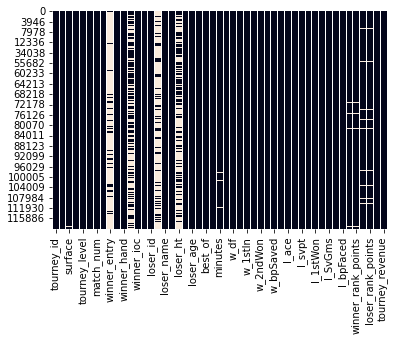

In [10]:
sn.heatmap(df_matches.isnull(), cbar=False)

The dataset is still missing values, but before we solve this issue we need to work on the types and duplicated records.

###**Type casting**

Most of the attributes have a wrong type, we have to fix this issue.

In [11]:
df_matches.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size             float64
tourney_level          object
tourney_date          float64
match_num             float64
winner_id             float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id              float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of               float64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms               float64
w_bpSaved             float64
w_bpFaced 

In [12]:
df_matches['tourney_date']= df_matches['tourney_date'].astype(pd.Int32Dtype(), errors='ignore').astype(pd.StringDtype())
df_matches['tourney_date'] = pd.to_datetime(df_matches['tourney_date'], errors='coerce', format='%Y%m%d')
df_matches.iloc[:, [3, 6, 7, 11, 14, 18, 22]] = df_matches.iloc[:, [3, 6, 7, 11, 14, 18, 22]].astype("Int32", errors="ignore")
df_matches.iloc[:, 24:48] = df_matches.iloc[:, 24:48].astype("Int32", errors="ignore")
df_matches.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

tourney_id                    object
tourney_name                  object
surface                       object
draw_size                      Int32
tourney_level                 object
tourney_date          datetime64[ns]
match_num                      Int32
winner_id                      Int32
winner_entry                  object
winner_name                   object
winner_hand                   object
winner_ht                      Int32
winner_ioc                    object
winner_age                   float64
loser_id                       Int32
loser_entry                   object
loser_name                    object
loser_hand                    object
loser_ht                       Int32
loser_ioc                     object
loser_age                    float64
score                         object
best_of                        Int32
round                         object
minutes                        Int32
w_ace                          Int32
w_df                           Int32
w

###**Dropping useless features**

For our purpose, an analysis of the players, some features are not insteresting or straight useless, we decided to drop them.

We don't need the tourney name, since we don't differentiate between the tournaments (masters atp, top500 etc.), moreover we already have the tourney id and date.

In [13]:
df_matches = df_matches.drop("tourney_name", axis=1)

The draw size is useless and the tourney level can't be used to differentiate beewteen men and women, since the latter can play the same kind of tournaments of the former. For what concerns match_num, it's a progressive number for the matches of a tournament, sometimes is totally arbitrary, we don't need it.

In [14]:
df_matches = df_matches.drop(["draw_size", "tourney_level", "match_num"], axis=1)

Winner_entry (and loser_entry) is a string that shows if the player qualified by a wildcard, as a lucky loser etc., it's not a very useful attribute since no site lists them, moreover is the feature with the most missing values.

In [15]:
df_matches = df_matches.drop(["winner_entry", "loser_entry"], axis=1)

The last features we need to drop are tourney_revenue and tourney_spectators, the former is the amount of revenue generated by the tournament and not the winner prize which would have been really interesting. The latter is the amount of spectators of the entire tournament, not match to match, so we can't retrieve informations about how famous the players involved in a certain match are or if they can play better under more pressure.

In [16]:
df_matches = df_matches.drop(["tourney_revenue", "tourney_spectators"], axis=1)

###**Dropping Duplicates**

Since there shouldn't be any duplitcated matches, we need to find and drop them.

In [17]:
ndupl = df_matches.duplicated()
ndupl = df_matches[ndupl]
print("Number of duplicated matches: {0}, they are the {1}% of the total number of matches".format(len(ndupl), len(ndupl)/len(df_matches)*100))
ndupl

Number of duplicated matches: 302, they are the 0.3670215351708716% of the total number of matches


,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
12066,2017-1059,Hard,2017-11-13,214562,Ingrid Neel,U,<NA>,USA,19.411362,203475,Carol Zhao,R,<NA>,CAN,22.401095,6-7(7) 7-6(6) 6-2,3,Q1,154,7,10,124,84,53,14,16,7,13,9,17,151,90,54,21,16,14,22,704,27,150,390
12067,2017-1059,Hard,2017-11-13,206368,Veronika Kudermetova,R,175,RUS,20.555784,203576,Kai Lin Zhang,R,<NA>,CHN,27.791923,7-6(2) 7-5,3,Q1,104,4,6,87,54,36,13,12,5,10,0,8,82,50,23,15,12,3,9,255,217,208,274
12068,2017-1059,Hard,2017-11-13,203435,Dalila Jakupovic,R,<NA>,SLO,26.642026,211874,Victoria Rodriguez,U,<NA>,MEX,22.562628,6-2 6-3,3,Q1,69,0,2,46,29,19,8,9,2,5,0,3,60,42,19,6,8,5,11,242,228,262,204
12069,2017-1059,Hard,2017-11-13,201674,Sabina Sharipova,R,<NA>,UZB,23.192334,214541,Fanny Stollar,R,172,HUN,19.003422,6-1 7-6(2),3,Q1,80,2,4,71,43,30,13,10,3,6,4,7,80,45,27,10,9,7,12,196,299,238,231
12070,2017-1059,Hard,2017-11-13,211411,Nina Stojanovic,R,<NA>,SRB,21.289528,204291,Na Lae Han,L,<NA>,KOR,25.355236,7-6(3) 6-3,3,Q1,91,5,3,79,49,34,11,11,4,8,0,4,68,41,23,9,10,2,7,230,243,250,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177376,2020-1103,Hard,2020-03-02,203398,Danielle Lao,R,<NA>,USA,28.763860,213949,Hanna Chang,U,<NA>,USA,22.015058,6-1 5-7 6-2,3,Q1,170,0,3,119,86,54,16,14,12,15,3,7,84,52,30,14,13,3,9,198,296,295,184
177377,2020-1103,Hard,2020-03-02,201534,Asia Muhammed,R,<NA>,USA,28.911704,215064,Maria Mateas,U,<NA>,USA,20.616016,7-5 2-6 6-3,3,Q1,157,3,4,100,60,32,14,14,13,22,0,6,100,75,39,6,15,10,20,194,304,413,103
177378,2020-1103,Hard,2020-03-02,203398,Danielle Lao,R,<NA>,USA,28.763860,213949,Hanna Chang,U,<NA>,USA,22.015058,6-1 5-7 6-2,3,Q1,170,0,3,119,86,54,16,14,12,15,3,7,84,52,30,14,13,3,9,198,296,295,184
177379,2020-1103,Hard,2020-03-02,201534,Asia Muhammed,R,<NA>,USA,28.911704,215064,Maria Mateas,U,<NA>,USA,20.616016,7-5 2-6 6-3,3,Q1,157,3,4,100,60,32,14,14,13,22,0,6,100,75,39,6,15,10,20,194,304,413,103


We can drop all the duplicates now.

In [18]:
df_matches = df_matches.drop_duplicates()

##**Data Integration**

We have to deal with missing or duplicated values for each attribute.

In [19]:
print("NULL FIELDS:")
print(df_matches.isnull().any())

NULL FIELDS:
tourney_id            False
surface                True
tourney_date          False
winner_id             False
winner_name           False
winner_hand            True
winner_ht              True
winner_ioc            False
winner_age             True
loser_id              False
loser_name            False
loser_hand             True
loser_ht               True
loser_ioc             False
loser_age              True
score                 False
best_of               False
round                 False
minutes                True
w_ace                 False
w_df                  False
w_svpt                False
w_1stIn               False
w_1stWon              False
w_2ndWon              False
w_SvGms               False
w_bpSaved             False
w_bpFaced             False
l_ace                 False
l_df                  False
l_svpt                False
l_1stIn               False
l_1stWon              False
l_2ndWon              False
l_SvGms               False
l_bpSav

###**Fixing players' id and name**

In [20]:
winners = df_matches[["winner_id", "winner_name"]].rename(columns={"winner_id": "id", "winner_name": "name"})
losers = df_matches[["loser_id", "loser_name"]].rename(columns={"loser_id": "id", "loser_name": "name"})
p_w_l = winners.append(losers).drop_duplicates()
p_w_l

,id,name
0,105453,Kei Nishikori
1,106421,Daniil Medvedev
3,104542,Jo-Wilfried Tsonga
5,104871,Jeremy Chardy
8,200282,Alex De Minaur
...,...,...
177178,220371,Ellie Douglas
177223,220665,Brittany Collens
177445,223323,Barbora Palicova
177446,220434,Kristyna Lavickova


Check for players with more than one id.

In [21]:
num_ids = p_w_l["name"].value_counts().to_frame().rename(columns={"name":"id"})
print(num_ids)
ids = list(num_ids[num_ids["id"] > 1].index)
print("Players with more than one id:\n{0}".format(ids))

                      id
Guy Stokman            2
Giuseppe Tresca        2
Kuan Yi Lee            2
Saara Kunakunova       1
Emilio Nava            1
...                   ..
Ozan Cildir            1
Nizar Belmati          1
Conny Perrin           1
Sumit Nagal            1
Anirudh Chandrasekar   1

[4254 rows x 1 columns]
Players with more than one id:
['Guy Stokman', 'Giuseppe Tresca', 'Kuan Yi Lee']


There's only one player with an actual homonym (Kuan Yi Lee), one is a male (id 134120) and the other is female (id 221745), moreover we found that the actual name of the male player is Kuan-Yi, so we change his name to differentiate between the two players.

In [22]:
print(df_matches.loc[df_matches["loser_name"]=="Kuan Yi Lee", ["loser_id", "loser_name"]].drop_duplicates())
df_matches.loc[df_matches["winner_id"]==134120, "winner_name"] = "Kuan-Yi Lee"
df_matches.loc[df_matches["loser_id"]==134120, "loser_name"] = "Kuan-Yi Lee"

        loser_id   loser_name
6801      134120  Kuan Yi Lee
134884    221745  Kuan Yi Lee


For what concerns the other two players we assign them their last id.

In [23]:
print(df_matches.loc[df_matches["loser_name"]=="Giuseppe Tresca", ["tourney_date", "loser_id", "loser_name"]].drop_duplicates())
print(df_matches.loc[df_matches["loser_name"]=="Guy Stokman", ["tourney_date", "loser_id", "loser_name"]].drop_duplicates())

       tourney_date  loser_id       loser_name
71713    2016-11-21    206834  Giuseppe Tresca
74947    2016-04-11    206834  Giuseppe Tresca
75886    2016-08-22    206834  Giuseppe Tresca
105022   2019-04-08    207982  Giuseppe Tresca
112478   2018-11-19    207982  Giuseppe Tresca
113959   2018-04-09    207982  Giuseppe Tresca
      tourney_date  loser_id   loser_name
69477   2016-09-05    206883  Guy Stokman
79951   2017-09-04    207142  Guy Stokman


In [24]:
df_matches.loc[df_matches["winner_name"]=="Giuseppe Tresca", "winner_id"] = 207982
df_matches.loc[df_matches["loser_name"]=="Giuseppe Tresca", "loser_id"] = 207982
df_matches.loc[df_matches["winner_name"]=="Guy Stokman", "winner_id"] = 207142
df_matches.loc[df_matches["loser_name"]=="Guy Stokman", "loser_id"] = 207142

Now, let's see if there are ids shared by two or more players.

In [25]:
num_ids = p_w_l["id"].value_counts().to_frame().rename(columns={"id":"name"})
print(num_ids)
ids = list(num_ids[num_ids["name"] > 1].index)
print("Player shared by more than one player:\n{0}".format(ids))

        name
202420     2
202428     2
202426     2
206363     2
200033     2
...      ...
202693     1
106432     1
200594     1
202321     1
144774     1

[4237 rows x 1 columns]
Player shared by more than one player:
[202420, 202428, 202426, 206363, 200033, 202359, 202443, 202440, 206091, 206145, 205941, 206426, 202414, 206430, 202436, 202434, 202429, 202437, 202477, 202421]


In [26]:
df_id_players = df_matches[df_matches["loser_id"].isin(ids)][["loser_id", "loser_name"]].drop_duplicates()
df_id_players.sort_values("loser_id")

,loser_id,loser_name
78458,200033,Kushaan Nath
550,200033,Serena Williams
10233,202359,Marvin Moeller
31395,202359,Chin Wei Chan
98321,202414,Catherine Harrison
111259,202414,Alexandre Rotsaert
3699,202420,Aidan Mchugh
54017,202420,An Sophie Mestach
115939,202421,George Houghton
477,202421,Alison Van Uytvanck


As we can see from the dataframe, the ids are shared only beetween a male and female player, this is allowed since there exist different tours (ATP and WTA) for each sex, so we don't need to apply any change, moreover we won't work with ids so this won't affect our work.

###**Fixing surface**

We try to solve the null values in the "surface" feature, first we count how many tournaments and matches have no surfaces for pure statistical reasons. If a tournament is missing the surface we can retrieve it if at least one match of the same tournament has it.

In [27]:
# tournaments with no surface
tourney_no_surface = df_matches[pd.isnull(df_matches['surface'])]['tourney_id'].unique()

# matches with no surface
matches_no_surface = df_matches[df_matches['tourney_id'].isin(tourney_no_surface)][['tourney_id', 'surface']]

print("Number of tournaments without a surface: {0}".format(len(tourney_no_surface)))
print("Number of matches without a surface: {0}".format(len(matches_no_surface)))
print("Number of tournaments for which we can retrieve the surface: {0}".
      format(len(matches_no_surface[matches_no_surface['surface'].notnull()])))

Number of tournaments without a surface: 42
Number of matches without a surface: 117
Number of tournaments for which we can retrieve the surface: 0


Unluckily there are no tournaments for which we can retrieve the surface (all of them are from the Davis or Federation cup, where the surface changes from event to event), so we chose to sample such values from the distribution of the surfaces.

In [28]:
# all possible values of "surface" attribute normalized
surface_distribution = df_matches["surface"].value_counts(normalize=True)
print("Distribution of each surface:\n{0}\n".format(surface_distribution))
print("Distribution of each surface cumulative:\n{0}\n".format(surface_distribution.cumsum()))

# sample surfaces and assing them to each tournament
for tourney in tourney_no_surface:
  sampled_surface = surface_distribution.sample(weights=surface_distribution, axis=0).index[0]
  print("Tournament: {0}, Surface sampled: {1}".format(tourney, sampled_surface))
  surface_mask = df_matches["tourney_id"] == tourney
  df_matches.loc[surface_mask, "surface"] = df_matches.loc[surface_mask, "surface"].fillna(sampled_surface)

Distribution of each surface:
Hard      0.576327
Clay      0.360655
Grass     0.062884
Carpet    0.000134
Name: surface, dtype: float64

Distribution of each surface cumulative:
Hard      0.576327
Clay      0.936982
Grass     0.999866
Carpet    1.000000
Name: surface, dtype: float64

Tournament: 2017-W-FC-2017-G2-AM-A-M-ECU-CUB-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-A-M-ECU-URU-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-A-M-URU-CUB-01, Surface sampled: Clay
Tournament: 2017-W-FC-2017-G2-AM-B-M-DOM-BAR-01, Surface sampled: Clay
Tournament: 2017-W-FC-2017-G2-AM-B-M-GUA-BAR-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-B-M-GUA-DOM-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-C-M-PUR-HON-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-C-M-PUR-TTO-01, Surface sampled: Clay
Tournament: 2017-W-FC-2017-G2-AM-C-M-TTO-HON-01, Surface sampled: Hard
Tournament: 2017-W-FC-2017-G2-AM-D-M-BAH-PAN-01, Surface sampled: Clay
Tourn

Let's check if there are tournaments with more than one surface.

In [29]:
t_surfaces = df_matches[["tourney_id", "surface"]].drop_duplicates()
num_surface = t_surfaces["tourney_id"].value_counts().to_frame().rename(columns={"tourney_id":"surface"})
print(num_surface)
surfaces = list(num_surface[num_surface["surface"] > 1].index)
print("Tournaments with more than one surface:\n{0}".format(surfaces))

                                     surface
2016-5067                                  1
2017-W-FC-2017-WG-PO-RUS-BEL-01            1
2021-9456                                  1
2019-W-FC-2019-G1-AM-A-M-PAR-MEX-01        1
2017-7161                                  1
...                                      ...
2019-7853                                  1
2018-7434                                  1
2018-M-DC-2018-G2-EPA-M-EST-LTU-01         1
2017-1094                                  1
2018-9118                                  1

[2162 rows x 1 columns]
Tournaments with more than one surface:
[]


There are none, so we can plot the surface distribution.

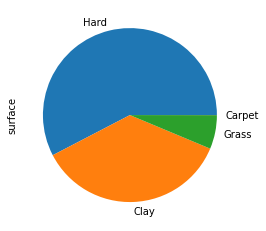

In [30]:
surface_distribution.plot(kind="pie")

In [31]:
df_matches["surface"].isnull().any()

False

###**Method for filling attributes**

We will use this method to check if for players that are missing some values we can actually retrieve them and then fill with the right values.

In [32]:
def fill_attribute_with_actual_values(attribute: str, value_to_replace=None):
    winner_attribute = "winner_" + attribute
    loser_attribute = "loser_" + attribute

    # player that have won or lost at least one match with unknown attribute
    if value_to_replace is not None:
        winner_unk_attribute = df_matches[df_matches[winner_attribute] == value_to_replace]['winner_name'].unique()
        loser_unk_attribute = df_matches[df_matches[loser_attribute] == value_to_replace]['loser_name'].unique()
    else:
        winner_unk_attribute = df_matches[pd.isna(df_matches[winner_attribute])]['winner_name'].unique()
        loser_unk_attribute = df_matches[pd.isna(df_matches[loser_attribute])]['loser_name'].unique()

    players_unk_attribute = set(np.concatenate((winner_unk_attribute, loser_unk_attribute)))
    print("Players with unknown {0}: {1}\n".format(attribute, len(players_unk_attribute)))

    # all the winners that appear in the players_unk_attribute set
    w = df_matches[df_matches['winner_name'].isin(players_unk_attribute)][['winner_name', winner_attribute]]
    if value_to_replace is not None:
        w = w[w[winner_attribute] != value_to_replace].drop_duplicates()
    else:
        w = w[w[winner_attribute].notnull()].drop_duplicates()

    # all the losers that appear in the players_unk_attribute set
    l = df_matches[df_matches['loser_name'].isin(players_unk_attribute)][['loser_name', loser_attribute]]
    if value_to_replace is not None:
        l = l[l[loser_attribute] != value_to_replace].drop_duplicates()
    else:
        l = l[l[loser_attribute].notnull()].drop_duplicates()

    l.rename(columns={'loser_name': 'player', loser_attribute: attribute}, inplace=True)
    w.rename(columns={'winner_name': 'player', winner_attribute: attribute}, inplace=True)

    # concatenate the winners and losers
    winner_loser_attribute = pd.concat([l, w]).drop_duplicates()
    print("Players that belong to records in which they have no {0} defined, but we retrieved it:\n{1}\n".format(attribute, winner_loser_attribute))

    for _, x in winner_loser_attribute.iterrows():
      attribute_actual_value = x[attribute]
      df_matches.loc[df_matches['winner_name'] == x['player'], winner_attribute] = attribute_actual_value
      df_matches.loc[df_matches['loser_name'] == x['player'], loser_attribute] = attribute_actual_value

###**Fixing winner_hand and loser_hand**

We have to manage the missing values for "winner_hand" and "loser_hand", for doing that we need to understand if the preferred hand is missing only in some records or it never appear for a certain player. Moreover, we have to verify if the missing hand for the winners is still null when those players appear inside the "loser_name" attribute (and viceversa).

For what concerns the preferred hand by both winners and losers, its possible values are "L", "R" or "U". Many records have null values and so we can assume that those values can be replace with "U".

In [33]:
df_matches['winner_hand'].fillna('U', inplace=True)
df_matches['loser_hand'].fillna('U', inplace=True)

Let's see if there are players with missing hand but, actually, their hand is already defined "L" or "R" inside one of the record of the dataset. The we can modify all the matches they belong to.

In [34]:
fill_attribute_with_actual_values("hand", "U")

Players with unknown hand: 1840

Players that belong to records in which they have no hand defined, but we retrieved it:
             player hand
99997  Amina Anshba    L



Now we will check if there are players that have more than one hand.

In [35]:
w_hand = df_matches[["winner_name", "winner_hand"]].rename(columns={"winner_name": "name", "winner_hand": "hand"})
l_hand = df_matches[["loser_name", "loser_hand"]].rename(columns={"loser_name": "name", "loser_hand": "hand"})
players_hand = w_hand.append(l_hand).drop_duplicates()
players_hand.value_counts()

name                  hand
Zvonimir Oreskovic    R       1
Georgii Kravchenko    R       1
Ghita Benhadi         U       1
Ghazal Pakbaten       U       1
Geronimo Barrios      U       1
                             ..
Milledge Cossu        R       1
Milka Emilia Pasanen  R       1
Miljan Zekic          R       1
Miliaan Niesten       U       1
Aaro Pollanen         R       1
Length: 4255, dtype: int64

Luckily there's none so we can proceed with the plot.

In [36]:
hand_distribution = players_hand["hand"].value_counts(normalize=True)
print("Distribution of each preferred hand:\n{0}\n".format(hand_distribution))

Distribution of each preferred hand:
R    0.501528
U    0.432197
L    0.066275
Name: hand, dtype: float64



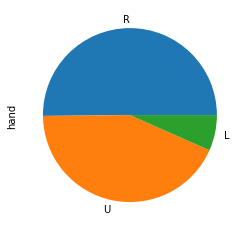

In [37]:
hand_distribution.plot(kind="pie")

In [38]:
print(df_matches["winner_hand"].isnull().any())
print(df_matches["loser_hand"].isnull().any())

False
False


###**Fixing winner_ht and loser_ht**

We do the same work as before, this time for the winners and losers height.

In [ ]:
fill_attribute_with_actual_values("ht")

There may be players with more than one height.

In [ ]:
w_ht = df_matches[["winner_name", "winner_ht"]].rename(columns={"winner_name": "name", "winner_ht": "ht"})
l_ht = df_matches[["loser_name", "loser_ht"]].rename(columns={"loser_name": "name", "loser_ht": "ht"})
p_ht = w_ht.append(l_ht).drop_duplicates()
num_ht = p_ht["name"].value_counts().to_frame().rename(columns={"name": "ht"})
print(num_ht)
ht = list(num_ht[num_ht["ht"] > 1].index)
print("PLayer with more than one ht:\n{0}".format(ht))

In [ ]:
df_matches[df_matches["loser_name"]=="David Goffin"][["loser_name", "loser_ht"]].drop_duplicates()

His real height is the first one so we need to fix every match where he appears.

In [ ]:
df_matches.loc[df_matches["winner_name"]=="David Goffin", "winner_ht"] = 180
df_matches.loc[df_matches["loser_name"]=="David Goffin", "loser_ht"] = 180

We'll work on the remaining missing values during the data preparation part since we will build a players dataset.

In [ ]:
print(df_matches["winner_ht"].isnull().any())
print(df_matches["loser_ht"].isnull().any())

###**Fixing winner_ioc and loser_ioc**

We fix the nationalities (ioc) of the players, since there are no missing values we only need to check if there are players with more than one ioc.

In [ ]:
df_matches[["winner_ioc", "loser_ioc"]].isnull().any()

In [ ]:
w_ioc = df_matches[["winner_name", "winner_ioc"]].rename(columns={"winner_name": "name", "winner_ioc": "ioc"})
l_ioc = df_matches[["loser_name", "loser_ioc"]].rename(columns={"loser_name": "name", "loser_ioc": "ioc"})
p_ioc = w_ioc.append(l_ioc).drop_duplicates()
p_ioc

There may be players with more than one ioc.

In [ ]:
num_ioc = p_ioc["name"].value_counts().to_frame().rename(columns={"name":"ioc"})
print(num_ioc)
ioc = list(num_ioc[num_ioc["ioc"] > 1].index)
print("PLayer with more than one ioc:\n{0}".format(ioc))

Luckily there's none but there still may be players with unknown ioc.

In [ ]:
print(p_ioc[p_ioc["ioc"]=="UNK"].value_counts())

The players is chinese actually, we change his ioc then.

In [ ]:
df_matches.loc[df_matches["winner_name"]=="Xinmu Zhou", "winner_ioc"] = "CHN"
df_matches.loc[df_matches["loser_name"]=="Xinmu Zhou", "loser_ioc"] = "CHN"

There are no players with two or more ioc, we can proceed with solving the issue regarding the ioc acronym. Those acronym (they actually are tags that show a player's nationality) are wrong sometimes since they don't follow the international standard (e.g.: GRE for Greece instead of GRC, or TPE for Taiwan instead of TWN) or some of them have both at the same time (e.g.: DEU and GER for Germany), we need to fix them, at least the ones we found.

In [ ]:
countries_wrong_ioc = ["GRE", "ALG", "CHI", "SUI", "SAM", "INA", "HON", "HAI", "MAS", "BUL", "SLO", "CRO", "DEN", "LAT", "POR", "VIE", "OMA", "GER", "NED", "PAR", "URU", "KUW", "TPE", "PHI"]
countries_correct_ioc = ["GRC", "DZA", "CHL", "CHE", "WSM", "IDN", "HDN", "HTI", "MSY", "BGR", "SVN", "HRV", "DNK", "LVA", "PRT", "VNM", "OMN", "DEU", "NLD", "PRY", "URY", "KWT", "TWN", "PHL"]

for wrong_ioc, correct_ioc in zip(countries_wrong_ioc, countries_correct_ioc):
    df_matches.loc[df_matches["winner_ioc"]==wrong_ioc, "winner_ioc"] = correct_ioc
    df_matches.loc[df_matches["loser_ioc"]==wrong_ioc, "loser_ioc"] = correct_ioc

###**Fixing winner_age and loser_age**

We try to solve the issue about missing values for those player that we can retrieve their actual age.

In [ ]:
import datetime, math

def birth_date(age, a_date):
    days = datetime.timedelta(math.ceil(age * 365) + int(age / 4))
    return a_date - days

def age_calc(birth_date, curr_date):
    days = (curr_date - birth_date).days
    age = days / 365
    age = age - int(age / 4) / 365
    return age

def assign_age(records, birth_d, feat):
    for i, x in records.iterrows():
        tourney_date: pd.Timestamp = x['tourney_date']
        py_date = tourney_date.to_pydatetime(warn=False)
        age = age_calc(birth_d, py_date)
        records.loc[i, feat] = age

In [ ]:
winner_unk_age = df_matches[df_matches['winner_age'].isna()]['winner_name'].unique()
loser_unk_age = df_matches[pd.isna(df_matches['loser_age'])]['loser_name'].unique()
players_unk_age = set(np.concatenate((winner_unk_age, loser_unk_age)))
print("Players with unknown {0}: {1}\n".format("age", len(players_unk_age)))

w = df_matches[df_matches['winner_name'].isin(players_unk_age)][['winner_name', 'winner_age', 'tourney_date']]
w = w[w['winner_age'].notnull()].drop_duplicates()
l = df_matches[df_matches['loser_name'].isin(players_unk_age)][['loser_name', 'loser_age', 'tourney_date']]
l = l[l['loser_age'].notnull()].drop_duplicates()

l.rename(columns={'loser_name': 'player', "loser_age": "age"}, inplace=True)
w.rename(columns={'winner_name': 'player', "winner_age": "age"}, inplace=True)

# concatenate the winners and losers
winner_loser_age = pd.concat([l, w]).drop_duplicates(subset="player")
print("Players that belong to records in which they have no {0} defined, but we retrieved it:\n{1}\n".format("age", winner_loser_age))

for _, x in winner_loser_age.iterrows():
    tourney_date: pd.Timestamp = x['tourney_date']
    py_date = tourney_date.to_pydatetime(warn=False)
    birth_d = birth_date(x['age'], py_date)
    records = df_matches[(df_matches['winner_name'] == x['player']) & (df_matches['winner_age'].isna())]
    assign_age(records, birth_d, 'winner_age')
    records = df_matches[(df_matches['loser_name'] == x['player']) & (df_matches['loser_age'].isna())]
    assign_age(records, birth_d, 'loser_age')
    df_matches.loc[records.index] = records

We will deal with the missing age players during the data preparation task, since having the player profile wuold simplify the work.

###**Fixing winner_rank and loser_rank**

In [ ]:
df_matches[["winner_rank", "loser_rank"]].isnull().any()

In [ ]:
w_rank = df_matches[["tourney_date", "winner_name", "winner_rank"]].rename(columns={"winner_name": "name", "winner_rank": "rank"})
w_rank.insert(len(w_rank.columns), "w_l", "w")
l_rank = df_matches[["tourney_date", "loser_name", "loser_rank"]].rename(columns={"loser_name": "name", "loser_rank": "rank"})
l_rank.insert(len(l_rank.columns), "w_l", "l")
p_rank = w_rank.append(l_rank).drop_duplicates()
p_rank = p_rank.sort_values(["name", "tourney_date"])
p_rank

In [ ]:
players_no_rank = p_rank[p_rank["rank"].isna()][["tourney_date", "name", "w_l"]]
players_rank = p_rank[p_rank["rank"].notna()][["tourney_date", "name", "w_l"]]
players_found_rank = players_no_rank[players_no_rank["name"].isin(players_rank["name"])]
for match, player in players_found_rank.iterrows():
    player_matches = p_rank.loc[p_rank["name"]==player["name"]]
    matches_before_tourney = player_matches[player_matches["tourney_date"]<player["tourney_date"]].dropna()  # matches played before the tournament where the player has no rank
    if len(matches_before_tourney) == 0:
        matches_after_tourney = player_matches[player_matches["tourney_date"]>player["tourney_date"]].dropna()  # matches player after the tournament where the player has no rank
        rank = int(matches_after_tourney.iloc[[0]]["rank"])
    else:
        rank = int(matches_before_tourney.iloc[[-1]]["rank"])
    
    if player["w_l"] == "w":
        df_matches.loc[(df_matches["winner_name"]==player["name"]) & (df_matches["tourney_date"]==player["tourney_date"]), "winner_rank"] = rank
    else:
        df_matches.loc[(df_matches["loser_name"]==player["name"]) & (df_matches["tourney_date"]==player["tourney_date"]), "loser_rank"] = rank

In [ ]:
players_no_rank["name"].drop_duplicates()  # players that appear in matches with no rank

In [ ]:
players_found_rank["name"].drop_duplicates()  # player for which we could find at least one rank

In [ ]:
players_no_rank_after_assignment = players_no_rank[~players_no_rank["name"].isin(players_rank["name"])]["name"].drop_duplicates()  # players with no rank found in any tournament
players_no_rank_after_assignment

It's safe to assume that those players with no rank don't have any points, so they share the rank and rank points.

In [ ]:
max_rank = df_matches["winner_rank"].max() + 1
for player in players_no_rank_after_assignment:
    df_matches.loc[df_matches["winner_name"]==player, "winner_rank"] = max_rank
    df_matches.loc[df_matches["loser_name"]==player, "loser_rank"] = max_rank

In [ ]:
df_matches[["winner_rank", "loser_rank"]].isnull().any()

###**Fixing winner_rank_points and loser_rank_points**

In [ ]:
df_matches[["winner_rank_points", "loser_rank_points"]].isnull().any()

In [ ]:
w_rank = df_matches[["tourney_date", "winner_name", "winner_rank_points"]].rename(columns={"winner_name": "name", "winner_rank_points": "rank_points"})
w_rank.insert(len(w_rank.columns), "w_l", "w")
l_rank = df_matches[["tourney_date", "loser_name", "loser_rank_points"]].rename(columns={"loser_name": "name", "loser_rank_points": "rank_points"})
l_rank.insert(len(l_rank.columns), "w_l", "l")
p_rank = w_rank.append(l_rank).drop_duplicates()
p_rank = p_rank.sort_values(["name", "tourney_date"])
p_rank

In [ ]:
players_no_rank = p_rank[p_rank["rank_points"].isna()][["tourney_date", "name", "w_l"]]
players_rank = p_rank[p_rank["rank_points"].notna()][["tourney_date", "name", "w_l"]]
players_found_rank = players_no_rank[players_no_rank["name"].isin(players_rank["name"])]
for match, player in players_found_rank.iterrows():
    player_matches = p_rank.loc[p_rank["name"]==player["name"]]
    matches_before_tourney = player_matches[player_matches["tourney_date"]<player["tourney_date"]].dropna()  # matches played before the tournament where the player has no rank points
    if len(matches_before_tourney) == 0:
        matches_after_tourney = player_matches[player_matches["tourney_date"]>player["tourney_date"]].dropna()  # matches player after the tournament where the player has no rank points
        rank_points = int(matches_after_tourney.iloc[[0]]["rank_points"])
    else:
        rank_points = int(matches_before_tourney.iloc[[-1]]["rank_points"])
    
    if player["w_l"] == "w":
        df_matches.loc[(df_matches["winner_name"]==player["name"]) & (df_matches["tourney_date"]==player["tourney_date"]), "winner_rank_points"] = rank_points
    else:
        df_matches.loc[(df_matches["loser_name"]==player["name"]) & (df_matches["tourney_date"]==player["tourney_date"]), "loser_rank_points"] = rank_points

In [ ]:
players_no_rank["name"].drop_duplicates()  # players that appear in matches with no rank points

In [ ]:
players_found_rank["name"].drop_duplicates()  # player for which we could find at least one rank points

In [ ]:
players_no_rank_after_assignment = players_no_rank[~players_no_rank["name"].isin(players_rank["name"])]["name"].drop_duplicates()  # players with no rank points found in any tournament
players_no_rank_after_assignment

It's safe to assume that those players with no rank don't have any points, so they share the rank and rank points.

In [ ]:
min_rank_points = df_matches["winner_rank"].min() - 1
for player in players_no_rank_after_assignment:
    df_matches.loc[df_matches["winner_name"]==player, "winner_rank_points"] = min_rank_points
    df_matches.loc[df_matches["loser_name"]==player, "loser_rank_points"] = min_rank_points

In [ ]:
df_matches[["winner_rank_points", "loser_rank_points"]].isnull().any()

###**Some informations about the dataset after fixing**

In [ ]:
df_matches.info()

In [ ]:
df_matches.isnull().any()

##**Outlier Detection**

After dealing with the missing values, the next step is solving the issues with outliers.

In [19]:
df_matches.describe()

,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,81982.000000,42720.000000,81968.000000,81982.000000,34412.000000,81894.000000,81982.000000,81181.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81982.000000,81083.000000,81069.000000,78859.000000,78844.000000
mean,142046.528909,182.559410,25.951796,143759.311154,182.334360,25.812926,3.077017,97.747182,4.823388,2.855907,71.297004,44.270901,32.142848,14.460662,11.117880,3.538411,5.404137,3.535422,3.609365,73.573297,44.565112,28.046169,12.715657,10.943146,4.658608,8.864238,210.540570,832.907745,271.904881,584.807214
std,45273.448299,9.178338,4.367188,45661.367126,9.346803,4.487613,0.384843,41.478933,4.389558,2.420502,25.530921,16.950740,11.414119,5.935955,3.513673,3.108513,4.204083,3.831693,2.606058,24.996130,16.777904,12.274711,6.322835,3.498705,3.148033,3.967422,221.015676,1377.881648,300.313853,889.158150
min,100644.000000,2.000000,14.390144,100644.000000,2.000000,14.302533,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,105587.000000,177.000000,22.661191,105643.500000,177.000000,22.464066,3.000000,72.000000,2.000000,1.000000,53.000000,33.000000,24.000000,10.000000,9.000000,1.000000,2.000000,1.000000,2.000000,56.000000,33.000000,19.000000,8.000000,9.000000,2.000000,6.000000,68.000000,174.000000,87.000000,131.000000
50%,111453.000000,183.000000,25.631759,111794.000000,183.000000,25.541410,3.000000,91.000000,4.000000,2.000000,67.000000,42.000000,30.000000,14.000000,10.000000,3.000000,5.000000,2.000000,3.000000,69.000000,42.000000,26.000000,12.000000,10.000000,4.000000,8.000000,149.000000,398.000000,184.000000,309.000000
75%,201521.000000,188.000000,28.878850,201555.000000,188.000000,28.793977,3.000000,119.000000,7.000000,4.000000,87.000000,54.000000,38.000000,18.000000,14.000000,5.000000,8.000000,5.000000,5.000000,88.000000,54.000000,35.000000,16.000000,13.000000,6.000000,11.000000,281.000000,850.000000,333.000000,701.000000
max,238184.000000,211.000000,95.000000,239436.000000,211.000000,53.932923,5.000000,4756.000000,75.000000,114.000000,1957.000000,1330.000000,836.000000,304.000000,49.000000,209.000000,266.000000,67.000000,114.000000,1672.000000,893.000000,532.000000,399.000000,50.000000,120.000000,190.000000,2168.000000,16950.000000,2257.000000,16950.000000


###**Compute the quartiles**

We compute the first quartile, the third quartile, the median and the interquartile for each feature

In [20]:
Q1 = df_matches.quantile(0.25)  # first quartile
Q3 = df_matches.quantile(0.75)  # third quartile
IQR = Q3 - Q1  # interquartile

We compute the Lower Bound and the Upper Bound for each feature

In [21]:
L = (Q1 - 1.5 * IQR).astype('int64')  # lower bound
M = (df_matches.quantile(0.5)).astype('int64')  # median
U = (Q3 + 1.5 * IQR).astype('int64')  # upper bound

We define the number of bins for each attribute using the Sturges' formula.

In [22]:
num_features = df_matches.count()
num_bins = (np.log2(num_features)).astype('int64') + 1

###**Height feature**

In [23]:
w_ht = df_matches[["winner_name", "winner_ht"]].rename(columns={"winner_name": "name", "winner_ht": "ht"})
l_ht = df_matches[["loser_name", "loser_ht"]].rename(columns={"loser_name": "name", "loser_ht": "ht"})
df_ht = w_ht.append(l_ht).drop_duplicates()
df_ht

,name,ht
0,Kei Nishikori,178
1,Daniil Medvedev,198
3,Jo-Wilfried Tsonga,188
5,Jeremy Chardy,188
8,Alex De Minaur,183
...,...,...
177178,Ellie Douglas,<NA>
177223,Brittany Collens,<NA>
177445,Barbora Palicova,<NA>
177446,Kristyna Lavickova,<NA>


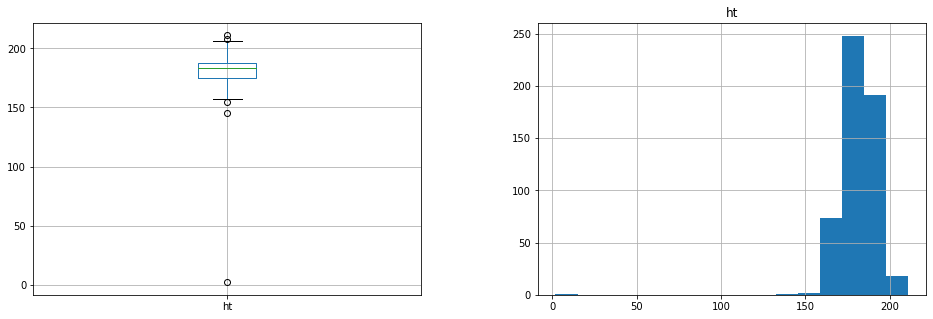

In [24]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_ht.boxplot(column="ht", ax=ax1)
df_ht.hist(column="ht", ax=ax2, stacked=True, bins=num_bins["winner_ht"])
fig.subplots_adjust(wspace=0.3)

We detect the outliers by using the bounds we defined by using the quartiles.

In [25]:
df_ht.loc[(df_ht["ht"] < L["winner_ht"]) | (df_ht["ht"] < L["loser_ht"]) | (df_ht["ht"] > U["winner_ht"]) | (df_ht["ht"] > U["loser_ht"])]

,name,ht
141,Ivo Karlovic,208
242,Reilly Opelka,211
676,Misaki Doi,159
720,Kurumi Nara,155
940,John Isner,206
1424,Lauren Davis,157
61084,Kamilla Rakhimova,2
70710,Ilija Vucic,145


The player Kamilla Rakhimova has an extremely wrong value, her real height is 174cm.

In [26]:
df_matches.loc[df_matches['winner_name'] == "Kamilla Rakhimova", "winner_ht"] = 174
df_matches.loc[df_matches['loser_name'] == "Kamilla Rakhimova", "loser_ht"] = 174
df_ht.loc[df_ht['name'] == "Kamilla Rakhimova", "ht"] = 174

Another player, Ilija Vucic, has the wrong height, it should be 188.

In [27]:
df_matches.loc[df_matches['winner_name'] == 'Ilija Vucic','winner_ht'] = 188
df_matches.loc[df_matches['loser_name'] == 'Ilija Vucic','loser_ht'] = 188
df_ht.loc[df_ht['name'] == "Ilija Vucic", "ht"] = 188

The very tall players, Karlovic and Opelka, are really that tall, we leave their height as it is.

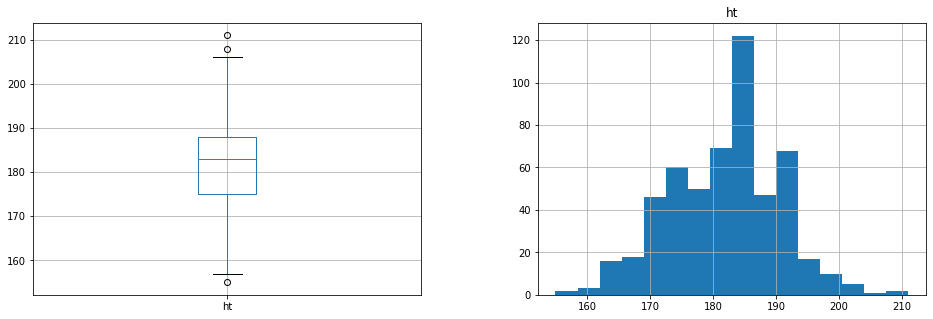

In [28]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_ht.boxplot(column="ht", ax=ax1)
df_ht.hist(column="ht", ax=ax2, stacked=True, bins=num_bins["winner_ht"])
fig.subplots_adjust(wspace=0.3)

###**Age feature**

In [29]:
w_age = df_matches[["winner_name", "winner_age"]].rename(columns={"winner_name":"name", "winner_age":"age"})
l_age = df_matches[["loser_name", "loser_age"]].rename(columns={"loser_name":"name", "loser_age": "age"})
df_age = w_age.append(l_age).drop_duplicates()
df_age

,name,age
0,Kei Nishikori,95.000000
1,Daniil Medvedev,22.885695
2,Kei Nishikori,29.004791
3,Jo-Wilfried Tsonga,33.705681
5,Jeremy Chardy,31.882272
...,...,...
177499,Marcela Zacarias,26.433949
177500,Ulrikke Eikeri,27.707050
177501,Denisa Allertova,27.485284
177502,Katherine Sebov,21.653662


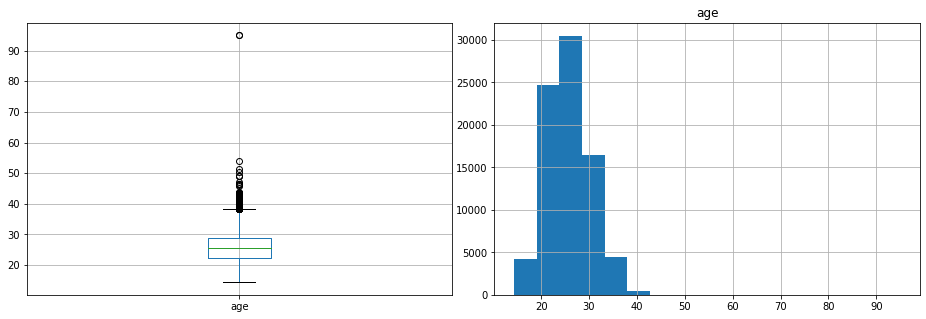

In [30]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_age.boxplot(column="age", ax=ax1)
df_age.hist(column="age", ax=ax2, stacked=True, bins=num_bins["winner_age"])
fig.subplots_adjust(wspace=0.1)

In [31]:
df_age.loc[(df_age["age"] < L["winner_age"]) | (df_age["age"] < L["loser_age"])]

,name,age


There are only players too old as outliers.

In [32]:
df_age.loc[(df_age["age"] > 1.5*U["winner_age"]) | (df_age["age"] > 1.5*U["loser_age"])]

,name,age
0,Kei Nishikori,95.0
322,Daniil Medvedev,95.0


The only players with wrong age are Nishikori and Medvedev, we fix these values which appears only on the winner_age feature.

In [33]:
df_matches.loc[df_matches['winner_name'] == 'Kei Nishikori', ['winner_age', "tourney_date"]]

,winner_age,tourney_date
0,95.000000,2018-12-31
2,29.004791,2018-12-31
6,29.004791,2018-12-31
14,29.004791,2018-12-31
324,29.043121,2019-01-14
...,...,...
109413,28.084873,2018-01-29
109415,28.084873,2018-01-29
109416,28.084873,2018-01-29
162711,26.168378,2016-03-04


In [34]:
df_matches.loc[0, 'winner_age'] = df_matches.loc[2, 'winner_age']
df_age.loc[0, 'age'] = df_matches.loc[2, 'winner_age']

In [35]:
df_matches.loc[df_matches['winner_name'] == 'Daniil Medvedev', ['winner_age', 'tourney_date']]

,winner_age,tourney_date
1,22.885695,2018-12-31
4,22.885695,2018-12-31
9,22.885695,2018-12-31
322,95.000000,2019-01-14
338,22.924025,2019-01-14
...,...,...
78978,20.892539,2017-01-02
78983,20.892539,2017-01-02
78985,20.892539,2017-01-02
83310,21.697467,2017-10-23


In [36]:
df_matches.loc[322, 'winner_age'] = df_matches.loc[338, 'winner_age']
df_age.loc[322, 'age'] = df_matches.loc[338, 'winner_age']

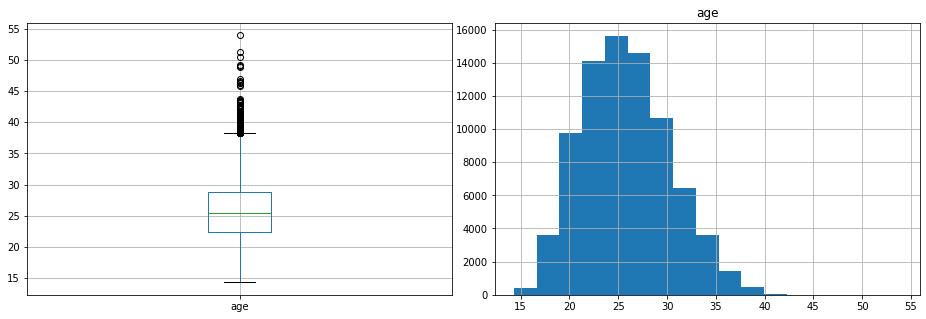

In [37]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_age.boxplot(column="age", ax=ax1)
df_age.hist(column="age", ax=ax2, stacked=True, bins=num_bins["winner_age"])
fig.subplots_adjust(wspace=0.1)

###**Minutes feature** 

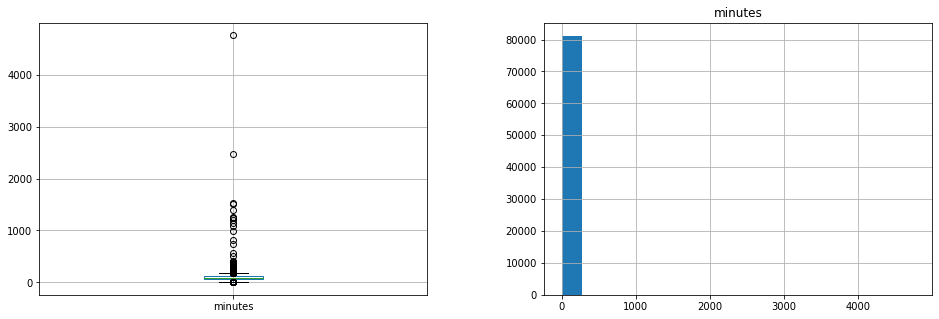

In [38]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column="minutes", ax=ax1)
df_matches.hist(column="minutes", ax=ax2, stacked=True, bins=num_bins["minutes"])
fig.subplots_adjust(wspace=0.3)

There are very long matches.

In [39]:
df_matches.loc[df_matches['minutes'] > 2*U['minutes'], ["score", 'minutes']]

,score,minutes
1990,7-6(5) 2-6 7-6(2),510
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,396
30862,6-1 3-6 6-3,1211
35073,6-3 4-6 6-0,1094
54162,6-4 6-4,814
57206,7-6(5) 6-3,1146
57322,7-5 6-1,1531
62351,6-3 6-4,740
63007,6-3 6-7(11) 6-2,1266
67025,6-2 6-3,1237


We replace them with the Upper Bound, except the match number 9679 which really lasted that long, look at the score.

In [40]:
df_matches.loc[df_matches['minutes'] > 2*U['minutes'], 'minutes'] = U['minutes']
df_matches.loc[9679, "minutes"] = 396

We detect too short matches too.

In [41]:
df_matches.loc[df_matches['minutes'] < L['minutes'], 'minutes']

248       0
2271      0
2449      0
3358      0
6051      0
         ..
117167    0
117243    0
117454    0
117990    0
118323    0
Name: minutes, Length: 87, dtype: Int32

In [42]:
df_matches.loc[df_matches['minutes'] < L['minutes'], 'minutes'].value_counts()

0    87
Name: minutes, dtype: Int64

This issue can be explained by the fact that there are many games with very few minutes (many with 0) that move the distribution towards this value.

In [43]:
df_matches.loc[df_matches['minutes'] < L['minutes'], 'score'].value_counts()

W/O            82
7-5 2-0 RET     1
7-5 6-1         1
3-6 6-3 6-4     1
6-2 6-2         1
6-3 6-2         1
Name: score, dtype: int64

As we can see, the short matches are almost entirely W/O, this means that the match didn't take place (the losing player didn't show up for the match or forfeited before the start). We can't modify the minutes then.

In [44]:
(df_matches.loc[df_matches['minutes'] < L['minutes']]).loc[df_matches['score'].str.find('W/O')>-1]

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
2271,2019-M021,Clay,2019-05-06,201549,Petra Martic,R,181,CRO,28.292950,201493,Angelique Kerber,L,173,GER,31.296372,W/O,3,R32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,1470,4,5220
2449,2019-M009,Clay,2019-05-13,202428,Kiki Bertens,R,182,NED,27.422313,211768,Naomi Osaka,R,180,JPN,21.571526,W/O,3,QF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5115,1,6356
3358,2019-M016,Grass,2019-06-24,201493,Angelique Kerber,L,173,GER,31.430527,202460,Ons Jabeur,R,167,TUN,24.821355,W/O,3,SF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4685,62,885
6051,2018-M020,Hard,2018-01-01,215035,Dayana Yastremska,R,175,UKR,17.631759,212001,Natalia Vikhlyantseva,R,<NA>,RUS,20.873374,W/O,3,Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,188,306,62,961
7784,2018-M007,Hard,2018-03-19,202469,Garbine Muguruza,R,182,ESP,24.443532,216153,Amanda Anisimova,R,<NA>,USA,16.547570,W/O,3,R64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5970,130,481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117167,2020-1003,Hard,2020-02-24,201320,Svetlana Kuznetsova,R,174,RUS,34.661191,216153,Amanda Anisimova,R,<NA>,USA,18.483231,W/O,3,R16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,1178,29,1613
117243,2020-2011,Hard,2020-03-02,206219,Oceane Dodin,R,<NA>,FRA,23.353867,213525,Jil Belen Teichmann,L,<NA>,SUI,22.631075,W/O,3,R16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130,487,66,896
117454,2020-1082,Clay,2020-08-10,202536,Ana Bogdan,R,<NA>,ROU,27.707050,201615,Lesia Tsurenko,R,174,UKR,31.197810,W/O,3,R16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,710,139,460
117990,2018-1090,Clay,2018-06-05,202663,Magda Linette,R,171,POL,26.310746,201506,Sara Errani,R,164,ITA,31.101985,W/O,3,SF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,865,75,813


What to do with the others? A possible solution is to replace them with the median

In [45]:
(df_matches.loc[df_matches['minutes'] < L['minutes']]).loc[df_matches['score'].str.find('W/O')==-1]

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
248,2019-M001,Hard,2019-01-07,201325,Samantha Stosur,R,172,AUS,34.773443,201495,Dominika Cibulkova,R,161,SVK,29.672827,3-6 6-3 6-4,3,R32,0,15,3,94,56,43,19,14,6,7,2,6,84,55,38,18,14,4,6,73,800,26,1805
7879,2018-M007,Hard,2018-03-19,212001,Natalia Vikhlyantseva,R,<NA>,RUS,21.084189,215306,Emiliana Arango,R,<NA>,COL,17.303217,6-3 6-2,3,Q1,0,4,1,54,28,23,15,9,1,1,0,2,51,20,9,18,8,4,7,88,709,517,59
29782,2017-0804,Clay,2017-04-03,201496,Caroline Wozniacki,R,177,DEN,26.729637,202470,Annika Beck,R,170,GER,23.126626,7-5 6-1,3,R32,0,2,3,68,55,32,7,10,8,11,0,1,50,37,17,3,9,1,7,12,3810,61,925
98553,2021-2030,Hard,2021-02-22,201483,Madison Brengle,R,<NA>,USA,30.891170,215018,Destanee Aiava,R,<NA>,AUS,20.788501,6-2 6-2,3,Q1,0,0,3,43,27,22,11,8,2,2,1,4,60,35,22,8,8,5,9,81,969,208,329
104107,2019-7085,Clay,2019-09-16,105063,Andrea Arnaboldi,L,<NA>,ITA,31.720739,106117,Carlos Boluda Purkiss,R,165,ESP,26.647502,7-5 2-0 RET,3,R64,0,2,0,47,30,25,8,7,4,4,1,3,53,26,17,12,7,5,7,299,135,408,85


In [46]:
df_matches.loc[[248,7879,29782,98553,104107], 'minutes'] = M['minutes']

There are short matches with normal scores, we assign them the median value.

In [47]:
(df_matches.loc[(df_matches['minutes'] < 10) & (df_matches["minutes"]>0)]).loc[df_matches['score'].str.find('RET')==-1]

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
98430,2021-2032,Hard,2021-02-03,204426,Anett Kontaveit,R,174,EST,25.114305,201458,Victoria Azarenka,R,180,BLR,31.512663,W/O,3,QF,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,2330,13,3426
117688,2020-W-FC-2020-G1-AO-A-M-CHN-INA-01,Hard,2020-03-04,202453,Saisai Zheng,R,170,CHN,26.075291,222145,Janice Tjen,U,<NA>,INA,NaN,6-1 6-1,3,RR,4,2,0,37,19,15,13,7,0,0,2,7,53,32,13,8,7,3,8,34,1510,<NA>,<NA>
117706,2020-W-FC-2020-G1-AO-A-M-IND-UZB-01,Hard,2020-03-04,206105,Rutuja Bhosale,R,<NA>,IND,23.937029,201454,Akgul Amanmuradova,R,<NA>,UZB,35.696099,2-6 6-2 7-5,3,RR,9,0,8,96,68,42,6,14,5,12,5,8,134,88,48,17,14,22,30,433,95,398,110
117714,2020-W-FC-2020-G1-AO-A-M-TPE-KOR-01,Hard,2020-03-04,204294,Su Jeong Jang,R,<NA>,KOR,24.977413,222390,Ya Yi Yang,L,<NA>,TPE,15.761807,6-3 6-1,3,RR,5,2,4,58,38,25,11,8,7,8,0,2,63,42,21,8,8,8,13,309,170,852,20


In [48]:
df_matches.loc[[117688,117706,117714], 'minutes'] = M['minutes']

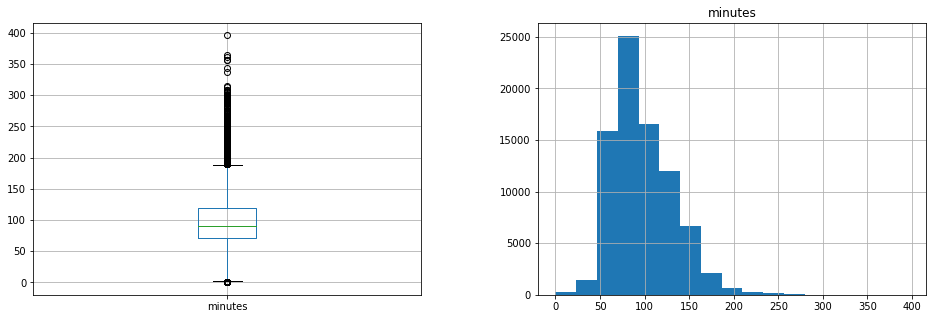

In [49]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column="minutes", ax=ax1)
df_matches.hist(column="minutes", ax=ax2, stacked=True, bins=num_bins["minutes"])
fig.subplots_adjust(wspace=0.3)

###**Ace feature**

The ace attribute, like all other player-related match statistics, is a positive integer variable which can also be 0. So for these attributes we will only look for outlier values that are too high, making sure there are no negative values

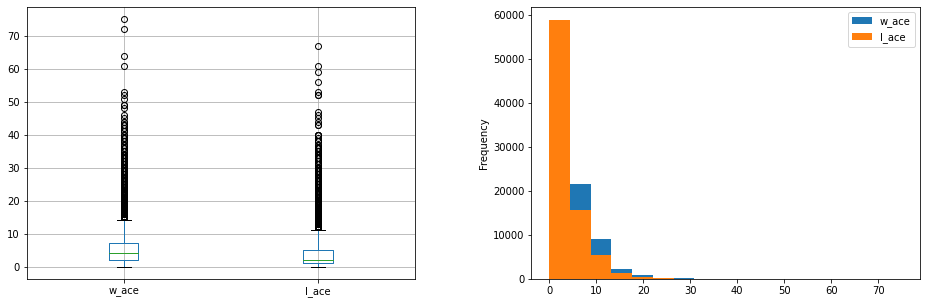

In [50]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_ace", "l_ace"], ax=ax1)
df_matches[["w_ace", "l_ace"]].plot.hist(ax=ax2, bins=num_bins["w_ace"])
fig.subplots_adjust(wspace=0.3)

There are high values.

In [51]:
df_matches.loc[df_matches['w_ace'] > 3*U['w_ace'], ["winner_name", 'w_ace']]

,winner_name,w_ace
21,Nick Kyrgios,44
937,Reilly Opelka,43
938,Reilly Opelka,43
4659,Alexander Bublik,48
6351,Ivo Karlovic,53
7936,John Isner,43
9631,John Isner,64
9679,Kevin Anderson,49
32440,Gilles Muller,45
33343,Ivo Karlovic,75


Same analysis for the losers.

In [52]:
df_matches.loc[df_matches['l_ace'] > 3*U['l_ace'], ["loser_name", 'l_ace']]

,loser_name,l_ace
139,Ivo Karlovic,36
310,John Isner,47
369,Ivo Karlovic,59
427,Reilly Opelka,67
938,John Isner,38
962,Ivo Karlovic,37
3461,Ivo Karlovic,38
3481,John Isner,34
4682,John Isner,40
5134,John Isner,35


It could seem strange but those values are absolutely possible, those players are known for this peculiar fact.

###**Double faults**


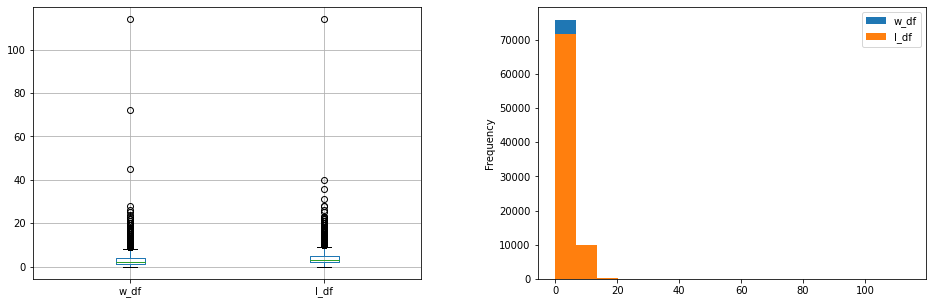

In [53]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_df", "l_df"], ax=ax1)
df_matches[["w_df", "l_df"]].plot.hist(ax=ax2, bins=num_bins["w_df"])
fig.subplots_adjust(wspace=0.3)

In [54]:
df_matches.loc[df_matches['w_df'] > 3*U['w_df'], ["score", 'w_df']]

,score,w_df
4659,6-7(3) 5-7 6-4 6-3 6-3,26
5236,7-5 3-6 7-5,25
99364,1-6 7-6(6) 6-0,114
99567,6-4 7-6(6),72
99631,3-6 7-5 7-6(3),28
99994,5-7 7-5 6-1,45


In [55]:
df_matches.loc[df_matches['w_df'] > 3*U['w_df'], 'w_df'] = U['w_df']

In [56]:
df_matches.loc[df_matches['l_df'] > 3*U['l_df'], ["score", 'l_df']]

,score,l_df
4943,1-6 7-5 7-6(5),28
86238,5-7 7-5 6-4,31
99364,1-6 7-6(6) 6-0,114
99384,7-5 6-4,40
99631,3-6 7-5 7-6(3),28
99994,5-7 7-5 6-1,36


In [57]:
df_matches.loc[df_matches['l_df'] > 3*U['l_df'], 'l_df'] = U['l_df']

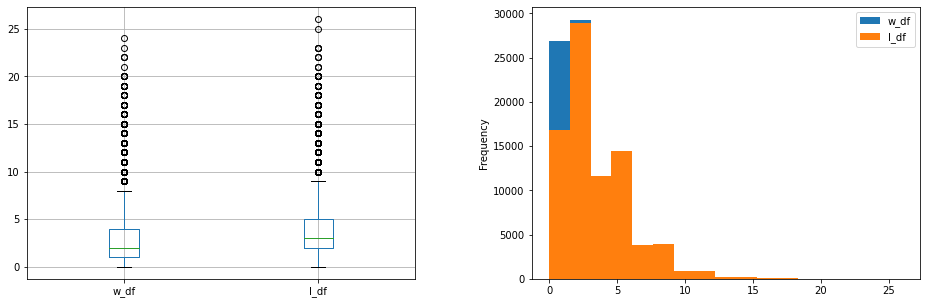

In [58]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_df", "l_df"], ax=ax1)
df_matches[["w_df", "l_df"]].plot.hist(ax=ax2, bins=num_bins["w_df"])
fig.subplots_adjust(wspace=0.3)

###**Serve Points**


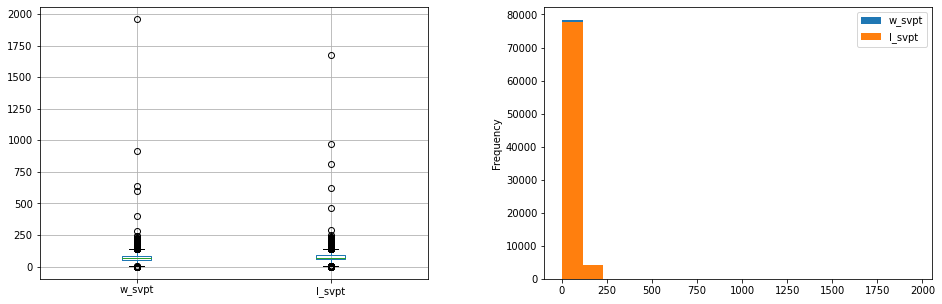

In [59]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_svpt", "l_svpt"], ax=ax1)
df_matches[["w_svpt", "l_svpt"]].plot.hist(ax=ax2, bins=num_bins["w_svpt"])
fig.subplots_adjust(wspace=0.3)

In [60]:
df_matches.loc[df_matches['w_svpt'] > 2*U['w_svpt'], ["score", 'w_svpt']]

,score,w_svpt
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,278
99364,1-6 7-6(6) 6-0,1957
99384,7-5 6-4,600
99567,6-4 7-6(6),640
99631,3-6 7-5 7-6(3),400
99994,5-7 7-5 6-1,918


In [61]:
df_matches.loc[df_matches['w_svpt'] > 2*U['w_svpt'], 'w_svpt'] = U['w_svpt']

In [62]:
df_matches.loc[df_matches['l_svpt'] > 2*U['l_svpt'], ["score", 'l_svpt']]

,score,l_svpt
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,291
99364,1-6 7-6(6) 6-0,1672
99384,7-5 6-4,810
99567,6-4 7-6(6),624
99631,3-6 7-5 7-6(3),464
99994,5-7 7-5 6-1,972


In [63]:
df_matches.loc[df_matches['l_svpt'] > 2*U['l_svpt'], 'l_svpt'] = U['l_svpt']

In [64]:
df_matches.loc[df_matches['w_svpt'] < L['w_svpt'], ["score", 'w_svpt']].value_counts()

score                   w_svpt
W/O                     0         85
0-0 RET                 0          3
1-0 RET                 0          2
0-1 RET                 0          2
6-4 7-5 5-7 0-6 7-6(5)  0          1
6-2 6-2                 1          1
5-7 7-6(6) 7-6(3)       0          1
1-0 RET                 1          1
dtype: int64

In [65]:
(df_matches.loc[df_matches["w_svpt"] < L["w_svpt"]]).loc[(df_matches['score'].str.find('W/O')==-1) & (df_matches["score"].str.find("RET")==-1)]

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
86150,2017-W-FC-2017-G1-EPA-D-M-SRB-BUL-01,Hard,2017-02-10,211411,Nina Stojanovic,R,<NA>,SRB,20.533881,202688,Isabella Shinikova,R,<NA>,BUL,25.297741,6-2 6-2,3,RR,<NA>,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,8,0,0,126,487,134,436
99889,2021-2036,Clay,2021-07-12,211736,Ivana Jorovic,R,<NA>,SRB,24.191650,211713,Jaqueline Adina Cristian,R,180,ROU,23.101985,5-7 7-6(6) 7-6(3),3,R32,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,334,177,153,509
162920,2017-M-DC-2017-G2-EPA-M-FIN-GEO-01,NaN,2017-02-03,106106,George Tsivadze,U,<NA>,GEO,24.076660,126609,Patrik Niklas Salminen,L,<NA>,FIN,19.906913,6-4 7-5 5-7 0-6 7-6(5),5,RR,<NA>,0,0,0,0,0,0,26,0,0,0,0,1,1,0,0,26,0,0,819,21,745,28


These three matches are missing almost all the values, we need to fill them.

In [66]:
df_matches.loc[[86150, 99889, 162920], ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved"]] = U[["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved"]]

In [67]:
features_to_fill = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced",
                   "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

for feature in features_to_fill:
    df_matches.loc[[86150, 99889, 162920], feature] = M[feature]

df_matches.loc[[86150, 99889, 162920]]

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
86150,2017-W-FC-2017-G1-EPA-D-M-SRB-BUL-01,Hard,2017-02-10,211411,Nina Stojanovic,R,<NA>,SRB,20.533881,202688,Isabella Shinikova,R,<NA>,BUL,25.297741,6-2 6-2,3,RR,<NA>,4,2,67,42,30,14,10,3,5,2,3,69,42,26,12,10,4,8,126,487,134,436
99889,2021-2036,Clay,2021-07-12,211736,Ivana Jorovic,R,<NA>,SRB,24.191650,211713,Jaqueline Adina Cristian,R,180,ROU,23.101985,5-7 7-6(6) 7-6(3),3,R32,200,4,2,67,42,30,14,10,3,5,2,3,69,42,26,12,10,4,8,334,177,153,509
162920,2017-M-DC-2017-G2-EPA-M-FIN-GEO-01,NaN,2017-02-03,106106,George Tsivadze,U,<NA>,GEO,24.076660,126609,Patrik Niklas Salminen,L,<NA>,FIN,19.906913,6-4 7-5 5-7 0-6 7-6(5),5,RR,<NA>,4,2,67,42,30,14,10,3,5,2,3,69,42,26,12,10,4,8,819,21,745,28


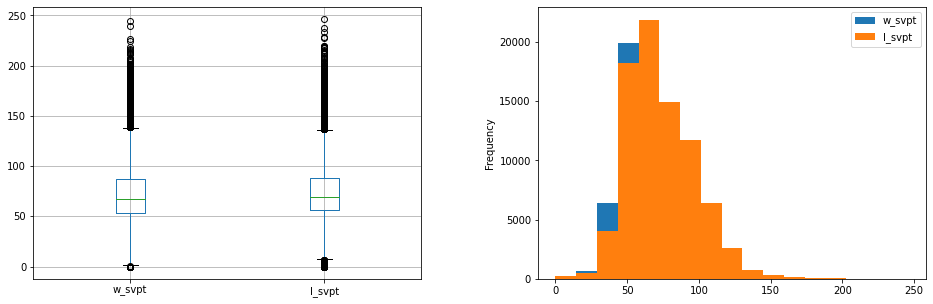

In [68]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_svpt", "l_svpt"], ax=ax1)
df_matches[["w_svpt", "l_svpt"]].plot.hist(ax=ax2, bins=num_bins["w_svpt"])
fig.subplots_adjust(wspace=0.3)

###**First Serve made**


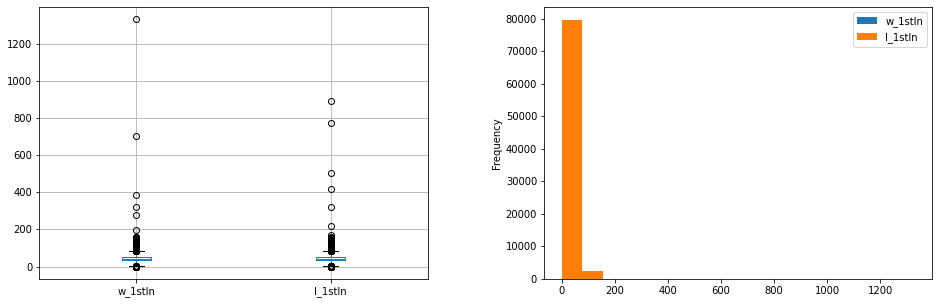

In [69]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_1stIn", "l_1stIn"], ax=ax1)
df_matches[["w_1stIn", "l_1stIn"]].plot.hist(ax=ax2, bins=num_bins["w_1stIn"])
fig.subplots_adjust(wspace=0.3)

In [70]:
df_matches.loc[df_matches['w_1stIn'] > 2*U['w_1stIn'], ["score", 'w_1stIn']]

,score,w_1stIn
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,198
99364,1-6 7-6(6) 6-0,1330
99384,7-5 6-4,320
99567,6-4 7-6(6),384
99631,3-6 7-5 7-6(3),276
99994,5-7 7-5 6-1,702


In [71]:
df_matches.loc[df_matches['w_1stIn'] > 2*U['w_1stIn'], 'w_1stIn'] = U['w_1stIn']
df_matches.loc[9679, "w_1stIn"] = 198

In [72]:
df_matches.loc[df_matches['l_1stIn'] > 2*U['l_1stIn'], ["score", 'l_1stIn']]

,score,l_1stIn
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,218
99364,1-6 7-6(6) 6-0,893
99384,7-5 6-4,420
99567,6-4 7-6(6),504
99631,3-6 7-5 7-6(3),320
99994,5-7 7-5 6-1,774


In [73]:
df_matches.loc[df_matches['l_1stIn'] > 2*U['l_1stIn'], 'l_1stIn'] = U['l_1stIn']
df_matches.loc[9679, "l_1stIn"] = 218

In [74]:
df_matches.loc[df_matches['w_svpt'] < L['w_svpt'], ["score", 'w_svpt']].value_counts()

score    w_svpt
W/O      0         85
0-0 RET  0          3
1-0 RET  0          2
0-1 RET  0          2
1-0 RET  1          1
dtype: int64

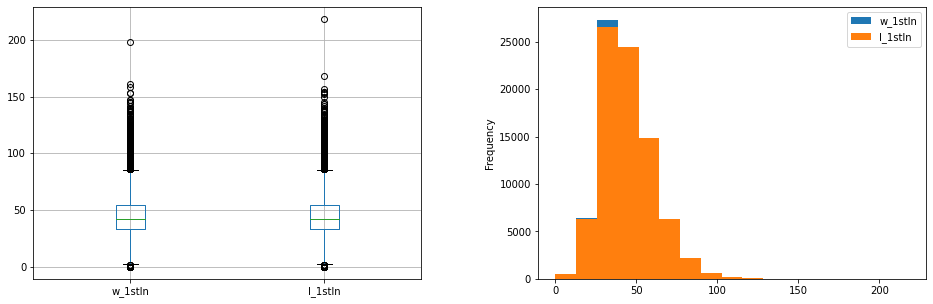

In [75]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_1stIn", "l_1stIn"], ax=ax1)
df_matches[["w_1stIn", "l_1stIn"]].plot.hist(ax=ax2, bins=num_bins["w_1stIn"])
fig.subplots_adjust(wspace=0.3)

###**First-Serve Points Won**


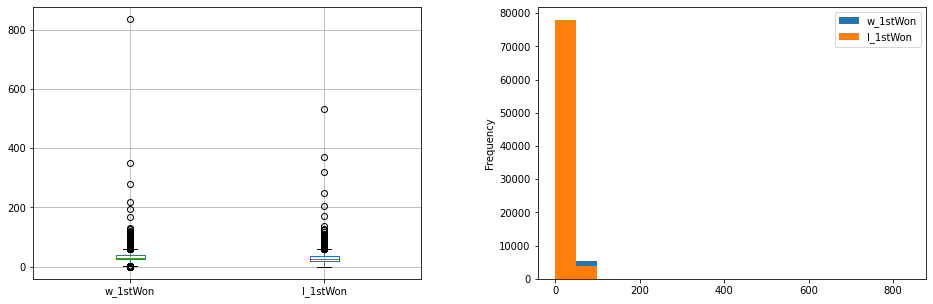

In [76]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_1stWon", "l_1stWon"], ax=ax1)
df_matches[["w_1stWon", "l_1stWon"]].plot.hist(ax=ax2, bins=num_bins["w_1stWon"])
fig.subplots_adjust(wspace=0.3)

In [77]:
df_matches.loc[df_matches['w_1stWon'] > 2*U['w_1stWon'], ["score", 'w_1stWon']]

,score,w_1stWon
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,166
33343,6-7(6) 3-6 7-5 6-2 22-20,127
55706,6-7(2) 6-3 7-6(3) 6-7(4) 12-10,120
56115,6-7(7) 7-6(5) 6-3 6-7(5) 14-12,126
56171,6-7(3) 3-6 7-6(5) 6-2 19-17,129
99364,1-6 7-6(6) 6-0,836
99384,7-5 6-4,220
99567,6-4 7-6(6),280
99631,3-6 7-5 7-6(3),196
99994,5-7 7-5 6-1,351


In [78]:
df_matches.loc[[99364, 99384, 99567, 99631, 99994], 'w_1stWon'] = U['w_1stWon']

In [79]:
df_matches.loc[df_matches['l_1stWon'] > 2*U['l_1stWon'], ["score", 'l_1stWon']]

,score,l_1stWon
9620,6-7(5) 3-6 7-6(4) 7-6(4) 13-11,127
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,171
33343,6-7(6) 3-6 7-5 6-2 22-20,125
56171,6-7(3) 3-6 7-6(5) 6-2 19-17,136
99364,1-6 7-6(6) 6-0,532
99384,7-5 6-4,250
99567,6-4 7-6(6),320
99631,3-6 7-5 7-6(3),204
99994,5-7 7-5 6-1,369


In [80]:
df_matches.loc[df_matches['l_1stWon'] > 2*U['l_1stWon'], 'l_1stWon'] = U['l_1stWon']
df_matches.loc[[99364, 99384, 99567, 99631, 99994], 'l_1stWon'] = U['l_1stWon']

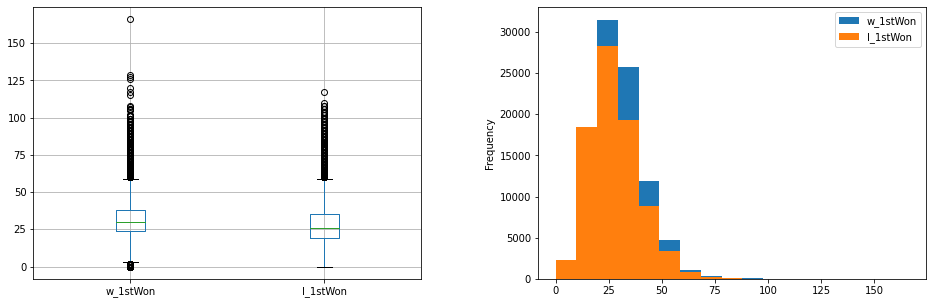

In [81]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_1stWon", "l_1stWon"], ax=ax1)
df_matches[["w_1stWon", "l_1stWon"]].plot.hist(ax=ax2, bins=num_bins["w_1stWon"])
fig.subplots_adjust(wspace=0.3)

###**Second-serve Points Won**


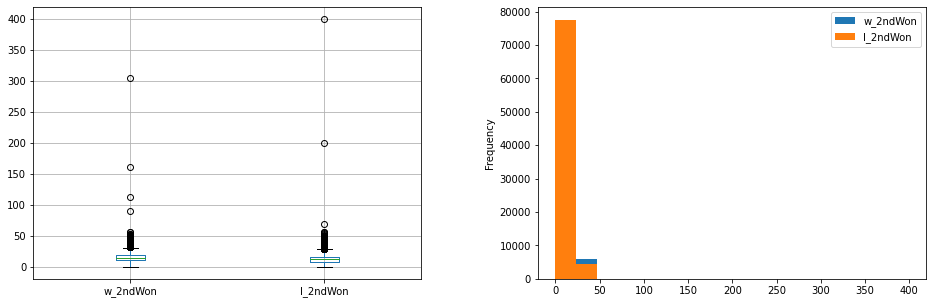

In [82]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_2ndWon", "l_2ndWon"], ax=ax1)
df_matches[["w_2ndWon", "l_2ndWon"]].plot.hist(ax=ax2, bins=num_bins["w_2ndWon"])
fig.subplots_adjust(wspace=0.3)

In [83]:
df_matches.loc[df_matches['w_2ndWon'] > 2*U['w_2ndWon'], ["score", 'w_2ndWon']]

,score,w_2ndWon
99364,1-6 7-6(6) 6-0,304
99384,7-5 6-4,160
99567,6-4 7-6(6),112
99994,5-7 7-5 6-1,90


In [84]:
df_matches.loc[df_matches['w_2ndWon'] > 2*U['w_2ndWon'], 'w_2ndWon'] = U['w_2ndWon']

In [85]:
df_matches.loc[df_matches['l_2ndWon'] > 2*U['l_2ndWon'], ["score", 'l_2ndWon']]

,score,l_2ndWon
99364,1-6 7-6(6) 6-0,399
99384,7-5 6-4,200
99631,3-6 7-5 7-6(3),68


In [86]:
df_matches.loc[df_matches['l_2ndWon'] > 2*U['l_2ndWon'], 'l_2ndWon'] = U['l_2ndWon']

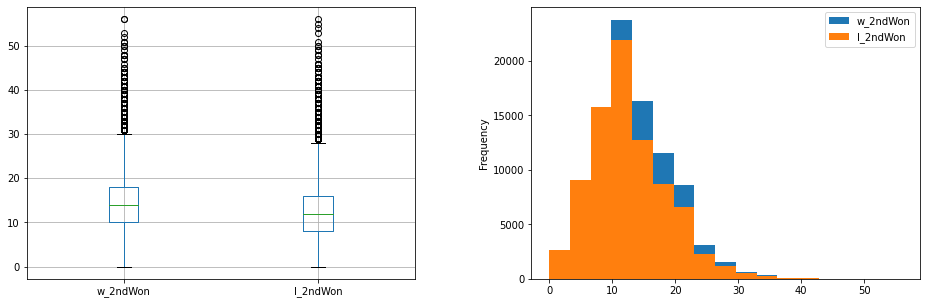

In [87]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_2ndWon", "l_2ndWon"], ax=ax1)
df_matches[["w_2ndWon", "l_2ndWon"]].plot.hist(ax=ax2, bins=num_bins["w_2ndWon"])
fig.subplots_adjust(wspace=0.3)

###**Serve Games**


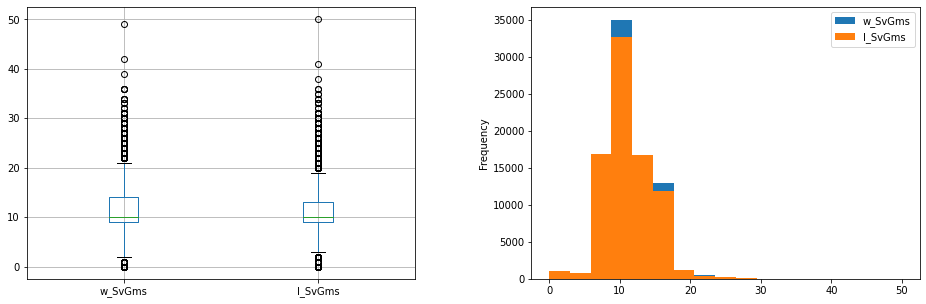

In [88]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_SvGms", "l_SvGms"], ax=ax1)
df_matches[["w_SvGms", "l_SvGms"]].plot.hist(ax=ax2, bins=num_bins["w_SvGms"])
fig.subplots_adjust(wspace=0.3)

In [89]:
df_matches.loc[df_matches['w_SvGms'] > 2*U['w_SvGms'], ["score", 'w_SvGms']]

,score,w_SvGms
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,49


The game is the longest in the entire dataset, this value is probably true.

In [90]:
df_matches.loc[df_matches['l_SvGms'] > 2*U['l_SvGms'], ["score", 'l_SvGms']]

,score,l_SvGms
9679,7-6(6) 6-7(5) 6-7(9) 6-4 26-24,50
33343,6-7(6) 3-6 7-5 6-2 22-20,41


Same thing as before, these values are true, we checked them.

###**Breakpoints Saved**


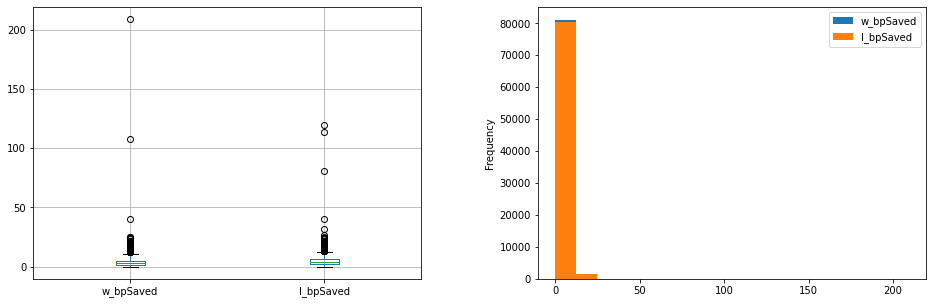

In [91]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_bpSaved", "l_bpSaved"], ax=ax1)
df_matches[["w_bpSaved", "l_bpSaved"]].plot.hist(ax=ax2, bins=num_bins["w_bpSaved"])
fig.subplots_adjust(wspace=0.3)

In [92]:
df_matches.loc[df_matches['w_bpSaved'] > 2*U['w_bpSaved'], ["score", 'w_bpSaved']]

,score,w_bpSaved
8967,6-7(2) 6-4 6-2,25
63117,7-5 4-6 6-4,23
99323,6-2 6-3,25
99364,1-6 7-6(6) 6-0,209
99384,7-5 6-4,40
99994,5-7 7-5 6-1,108
117350,5-7 6-4 6-4,24


In [93]:
df_matches.loc[df_matches['w_bpSaved'] > 2*U['w_bpSaved'], 'w_bpSaved'] = U['w_bpSaved']

In [94]:
df_matches.loc[df_matches['l_bpSaved'] > 2*U['l_bpSaved'], ["score", 'l_bpSaved']]

,score,l_bpSaved
57031,7-5 3-6 4-6 7-6 8-6,25
60395,6-7(5) 7-6(4) 3-6 6-4 6-1,27
99364,1-6 7-6(6) 6-0,114
99384,7-5 6-4,120
99567,6-4 7-6(6),32
99631,3-6 7-5 7-6(3),40
99994,5-7 7-5 6-1,81


In [95]:
df_matches.loc[df_matches['l_bpSaved'] > 2*U['l_bpSaved'], 'l_bpSaved'] = U['l_bpSaved']

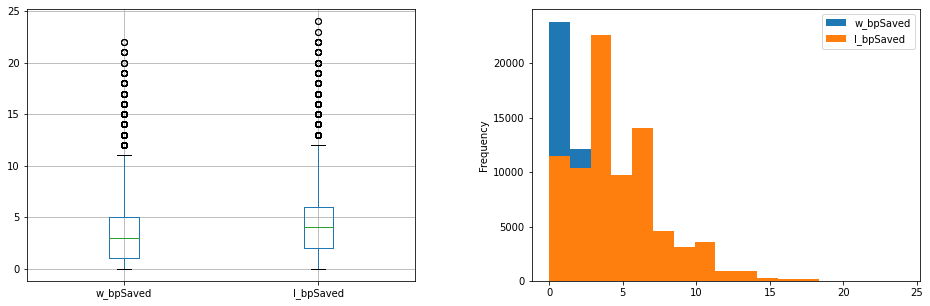

In [96]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_bpSaved", "l_bpSaved"], ax=ax1)
df_matches[["w_bpSaved", "l_bpSaved"]].plot.hist(ax=ax2, bins=num_bins["w_bpSaved"])
fig.subplots_adjust(wspace=0.3)

###**Breakpoints Faced**


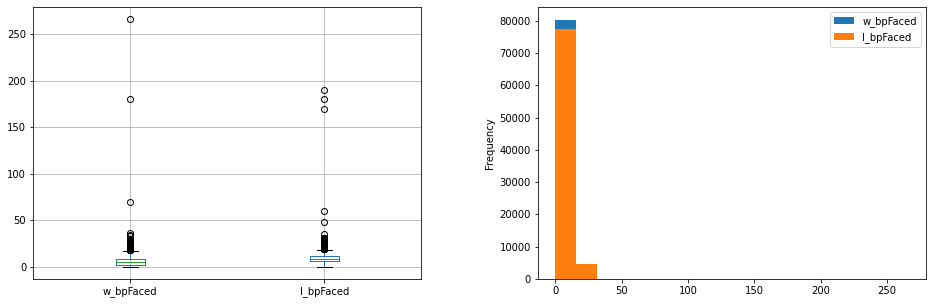

In [97]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_bpFaced", "l_bpFaced"], ax=ax1)
df_matches[["w_bpFaced", "l_bpFaced"]].plot.hist(ax=ax2, bins=num_bins["w_bpFaced"])
fig.subplots_adjust(wspace=0.3)

In [98]:
df_matches.loc[df_matches['w_bpFaced'] > 2*U['w_bpFaced'], ["score", 'w_bpFaced']]

,score,w_bpFaced
99364,1-6 7-6(6) 6-0,266
99384,7-5 6-4,70
99631,3-6 7-5 7-6(3),36
99994,5-7 7-5 6-1,180


In [99]:
df_matches.loc[df_matches['w_bpFaced'] > 2*U['w_bpFaced'], 'w_bpFaced'] = U['w_bpFaced']

In [100]:
df_matches.loc[df_matches['l_bpFaced'] > 2*U['l_bpFaced'], ["score", 'l_bpFaced']]

,score,l_bpFaced
99364,1-6 7-6(6) 6-0,190
99384,7-5 6-4,170
99567,6-4 7-6(6),48
99631,3-6 7-5 7-6(3),60
99994,5-7 7-5 6-1,180


In [101]:
df_matches.loc[df_matches['l_bpFaced'] > 2*U['l_bpFaced'], 'l_bpFaced'] = U['l_bpFaced']

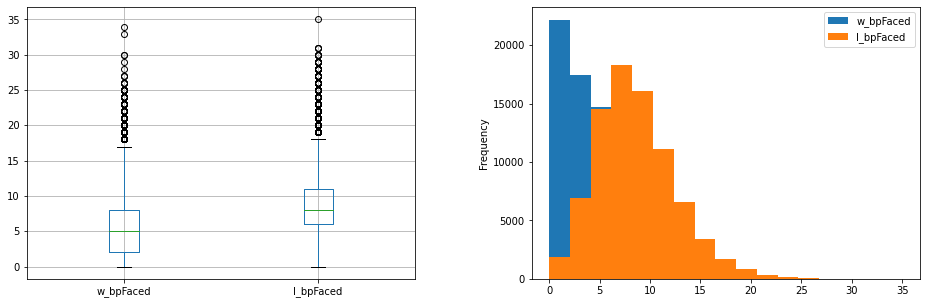

In [102]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["w_bpFaced", "l_bpFaced"], ax=ax1)
df_matches[["w_bpFaced", "l_bpFaced"]].plot.hist(ax=ax2, bins=num_bins["w_bpFaced"])
fig.subplots_adjust(wspace=0.3)

###**Player Rank**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


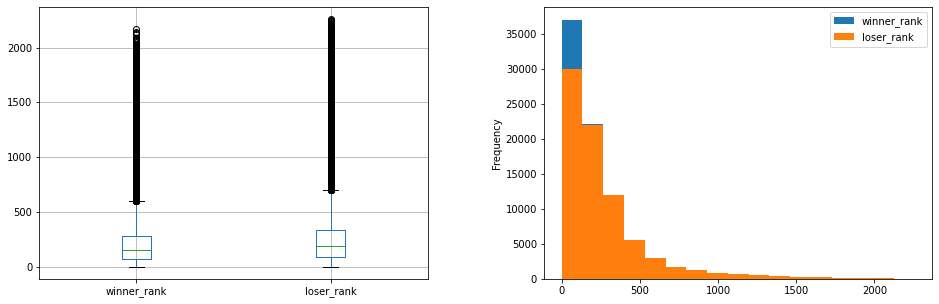

In [103]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["winner_rank", "loser_rank"], ax=ax1)
df_matches[["winner_rank", "loser_rank"]].plot.hist(ax=ax2, bins=num_bins["winner_rank"])
fig.subplots_adjust(wspace=0.3)

The are many players at the right end of the graph due to the fact that we assigned the same value to those players without any rank.

###**Ranking Points**


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


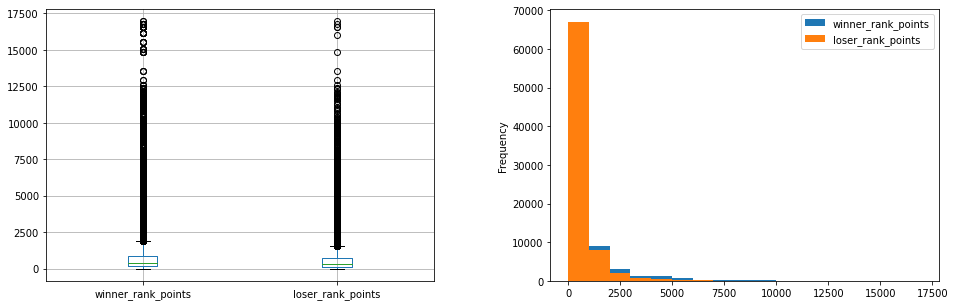

In [104]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_matches.boxplot(column=["winner_rank_points", "loser_rank_points"], ax=ax1)
df_matches[["winner_rank_points", "loser_rank_points"]].plot.hist(ax=ax2, bins=num_bins["winner_rank_points"])
fig.subplots_adjust(wspace=0.3)

Even if it seems like there are many outliers we've nothing to worry about since the points are awarded based on the tournament and the famous one gives the most points and those are the same won by the top players.

##**Correlations**
Let's see what are the correlations beetween the features.

In [105]:
numerical_features = ['winner_ht',	'winner_age', 'loser_ht',	'loser_age', 'best_of',	'minutes', 'w_ace',	'w_df',
                      'w_svpt',	'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',	'l_ace',
                      'l_df', 'l_svpt', 'l_1stIn',	'l_1stWon',	'l_2ndWon',	'l_SvGms', 'l_bpSaved',	'l_bpFaced',
                      'winner_rank',	'winner_rank_points',	'loser_rank',	'loser_rank_points']
df_matches_numerical=df_matches[numerical_features]  # we have to consider only numerical features

Let's plot the correlations.

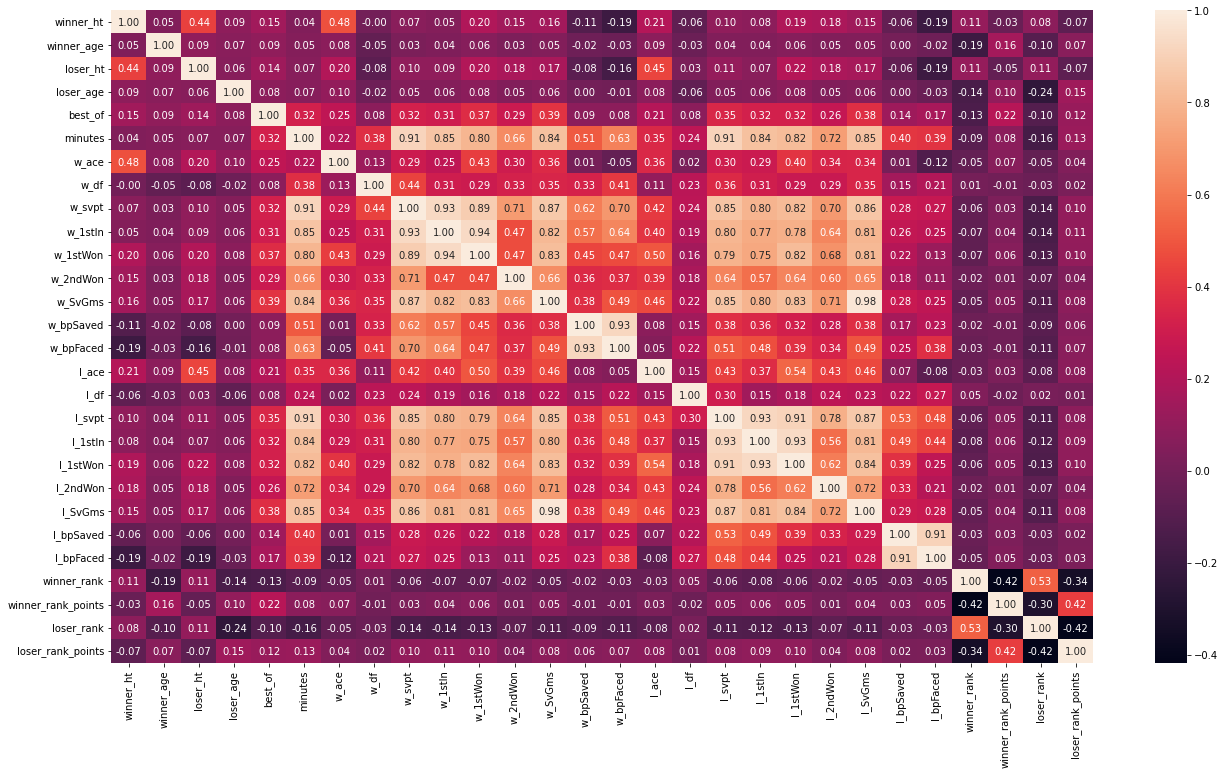

In [106]:
plt.pyplot.figure(figsize=(22, 12))
sn.heatmap(df_matches_numerical.corr(), annot=True, fmt=".2f")

Look for highly-correlated features (those with correlation |corr| > 0.8).

In [107]:
features = df_matches_numerical.columns
correl_matrix = np.array(df_matches_numerical.corr())
correl_attrib = []
n_row, n_col = correl_matrix.shape[0], correl_matrix.shape[1]

CORREL_THRESHOLD = 0.8

for i in range(n_row):
    for j in range(i + 1, n_col):
        if np.abs(correl_matrix[i, j]) > CORREL_THRESHOLD:
            correl_attrib.append((features[i], features[j]))

correl_attrib

[('minutes', 'w_svpt'),
 ('minutes', 'w_1stIn'),
 ('minutes', 'w_1stWon'),
 ('minutes', 'w_SvGms'),
 ('minutes', 'l_svpt'),
 ('minutes', 'l_1stIn'),
 ('minutes', 'l_1stWon'),
 ('minutes', 'l_SvGms'),
 ('w_svpt', 'w_1stIn'),
 ('w_svpt', 'w_1stWon'),
 ('w_svpt', 'w_SvGms'),
 ('w_svpt', 'l_svpt'),
 ('w_svpt', 'l_1stWon'),
 ('w_svpt', 'l_SvGms'),
 ('w_1stIn', 'w_1stWon'),
 ('w_1stIn', 'w_SvGms'),
 ('w_1stIn', 'l_svpt'),
 ('w_1stIn', 'l_SvGms'),
 ('w_1stWon', 'w_SvGms'),
 ('w_1stWon', 'l_1stWon'),
 ('w_1stWon', 'l_SvGms'),
 ('w_SvGms', 'l_svpt'),
 ('w_SvGms', 'l_1stWon'),
 ('w_SvGms', 'l_SvGms'),
 ('w_bpSaved', 'w_bpFaced'),
 ('l_svpt', 'l_1stIn'),
 ('l_svpt', 'l_1stWon'),
 ('l_svpt', 'l_SvGms'),
 ('l_1stIn', 'l_1stWon'),
 ('l_1stIn', 'l_SvGms'),
 ('l_1stWon', 'l_SvGms'),
 ('l_bpSaved', 'l_bpFaced')]

Since we used minutes only for checking "inusual matches" and it has a very high correlation with other features we decided to drop them. The other features are necessary to build the players profiles, so we keep them.

In [108]:
df_matches = df_matches.drop("minutes", axis=1)

##**Save the cleaned dataset**

The data understanding part is followed by the data preparation, we choose to save the cleaned dataframe in a gzip file since it mantains the dtypes (which the csv format doesn't), we show briefly an overview of the dataset before saving it.

In [109]:
df_matches

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,106421,Daniil Medvedev,R,198,RUS,22.885695,6-4 3-6 6-2,3,F,3,3,77,44,31,17,13,3,6,8,6,100,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,7-6(6) 6-2,3,SF,10,1,52,33,28,14,10,0,1,17,2,77,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,104871,Jeremy Chardy,R,188,FRA,31.882272,6-2 6-2,3,SF,2,2,47,33,26,9,8,2,2,10,3,46,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Hard,2018-12-31,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,200282,Alex De Minaur,R,183,AUS,19.868583,6-4 7-6(2),3,QF,12,2,68,43,34,15,11,4,5,1,2,81,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,105683,Milos Raonic,R,196,CAN,28.010951,6-7(2) 6-3 6-4,3,QF,12,3,105,68,48,25,16,8,8,29,5,94,56,46,19,15,2,4,16,1977,18,1855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177499,2020-2023,Clay,2020-08-31,215337,Olga Danilovic,L,<NA>,SRB,19.603012,204420,Marcela Zacarias,R,<NA>,MEX,26.433949,6-3 6-1,3,R128,1,2,45,20,15,14,8,3,5,0,0,64,51,20,7,8,3,9,174,363,259,225
177500,2020-2023,Clay,2020-08-31,202457,Bibiane Schoofs,R,170,NED,32.301164,205918,Ulrikke Eikeri,U,<NA>,NOR,27.707050,5-7 6-0 6-4,3,R128,3,5,93,62,36,15,14,4,9,1,3,84,48,22,18,14,3,11,190,326,250,245
177501,2020-2023,Clay,2020-08-31,212044,Katharina Gerlach,R,<NA>,GER,22.529774,202653,Denisa Allertova,R,<NA>,CZE,27.485284,6-2 6-1,3,R128,5,5,45,27,23,10,8,2,3,0,0,40,28,13,2,7,1,6,240,251,239,252
177502,2020-2023,Clay,2020-08-31,206037,Daniela Seguel,U,<NA>,CHI,27.791923,214684,Katherine Sebov,U,<NA>,CAN,21.653662,6-2 6-2,3,R128,0,0,54,38,23,8,8,3,5,0,4,59,46,18,5,8,4,10,224,269,257,233


In [110]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81982 entries, 0 to 177503
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          81982 non-null  object        
 1   surface             81865 non-null  object        
 2   tourney_date        81982 non-null  datetime64[ns]
 3   winner_id           81982 non-null  Int32         
 4   winner_name         81982 non-null  object        
 5   winner_hand         81966 non-null  object        
 6   winner_ht           42735 non-null  Int32         
 7   winner_ioc          81982 non-null  object        
 8   winner_age          81968 non-null  float64       
 9   loser_id            81982 non-null  Int32         
 10  loser_name          81982 non-null  object        
 11  loser_hand          81919 non-null  object        
 12  loser_ht            34426 non-null  Int32         
 13  loser_ioc           81982 non-null  object   

In [111]:
df_matches.to_parquet("cleaned_tennis_matches.gzip")

with zipfile.ZipFile("preparation_data.zip", "w") as zip_ref:
    zip_ref.write("male_players.csv")
    zip_ref.write("female_players.csv")
    zip_ref.write("cleaned_tennis_matches.gzip")